***
<h1><center>Capstone Project 20.1: Initial Report and Exploratory Data Analysis (EDA)</center></h1>
***
<h2><center>Project Name: Classification of Border Gateway Protocol Anomalies using Machine Learning</center></h2>
***
<h4><center>Shaji R. Nathan </h4><center>IP Infusion Inc.<center> Santa Clara, California<center> shaji.nathan@ipinfusion.com</center>

**Overview**: In this practical application, my goal is to compare  the performance of the machine learning based classifiers namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines in detecting protocol anomalies in Border Gateway Routing Protocol.  I will utilize Border Gateway Protocol (BGP) datasets with routing records collected from Reseaux IP Europeens (RIPE) and BCNET to implement an anomaly detection model. For the supervised learning datasets from five well-known anomalies are used. They are namely WannaCrypt, Moscow blackout, Slammer, Nimda, Code Red I, that occurred in May 2017, May 2005, January 2003, September 2001, and July 2001. The datasets were made publicly available by Reseaux IP Europeens (RIPE) Network Coordination Centre (NCC):__[RIPE](http://www.ensc.sfu.ca/~ljilja/cnl/projects/BGP_datasets/BGP_RIPE_datasets_for_anomaly_detection_csv_revised_19022021.zip)__.  The regular data is collected from IP Infusion's BGP gateways. Live BGP updates are also available from the Center for Applied Internet Data Analysis at UC San Diego. __[CAIDA](https://bgpstream.caida.org/data)__.   In this project we are looking to classify BGP updates on the provider edge routers in a typical 4G/5G backhaul network.  A typical backhaul network will look like the one shown below. The end goal is to use a route reflector in conjunction with the classifier to analyze the BGP updates from the gateways and push a packet filter rule to block anomalous BGP traffic whenever the classifier detects an anomalous BGP update. 

> The basic idea is to develop a classifier that takes in BGP update announcements and classifies it with a positive label (in case it’s an “anomaly”) assigns the numeric value of +1 (one), and a negative label (“for normal updates ”) assigns the numeric value of -1 (minus one).  The classifier is called by a BGP route reflector which pushes a route filter to the cell site gateway based on the administrators network policy when it gets a anomaly detected message from the classifier. 

<img src="dataset/Network.Diagram.png" alt="Alt BGP deployment in a Cell Site Backhaul Transport Network" title="Title text" />

 ### Step 1: Processing and Understanding the Data 

BGP update messages from the network are collected in multi-threaded routing toolkit (MRT) format. Then a protocol parser extract the BGP updated messages in ASCII. 
BGP features are extracted using a C# based tool to generate the datasets (csv files). Labels for anomalies are added based on the periods when data were collected.  We are primarily interested in the 37 features from the BGP update messages.  BGP packet trace from a sniffer tool the update message will look like so: 

<img src="dataset/BGPU.png" alt="BGP Update Message Packet Trace" title="Title text" />

In [1]:
import pandas as pd
import numpy as np 
import time
import missingno as msno

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# matplotlib and seaborn setting
plt.rcParams['figure.dpi'] = 150
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

sns.set(rc={'figure.figsize':(6,6)})
sns.set_theme(style="darkgrid")
# sns.set(font_scale=0.7)

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.inspection import permutation_importance

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, fbeta_score
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn import set_config
set_config(display='diagram')

In [8]:
import warnings
warnings.filterwarnings('ignore')

## Step 2: Read in the Data

In [9]:
code_redi_df = pd.read_csv("dataset/Code_Red_I.csv")
slammer_df = pd.read_csv("dataset/Slammer.csv")
nimda_df = pd.read_csv("dataset/Nimda.csv")

In [10]:
nimda_df.shape

(10048, 42)

### Combining the dataset

In [11]:
df = pd.concat([slammer_df,nimda_df]).reset_index(drop=True)

In [12]:
bgpdf=pd.concat([slammer_df,nimda_df,code_redi_df]).reset_index(drop=True)

In [13]:
df.shape

(17247, 42)

In [14]:
bgpdf.shape

(24446, 42)

In [15]:
df.head().T

0      1      2      3  \
Hour and Minutes                                     1.0    2.0    3.0    4.0   
Hour                                                 0.0    0.0    0.0    0.0   
Minutes                                              1.0    2.0    3.0    4.0   
Seconds                                              4.0    0.0   12.0    9.0   
Number of announcements                             40.0   59.0   52.0   49.0   
Number of withdrawals                                4.0    7.0    4.0    2.0   
Number of announced NLRI prefixes                  161.0  133.0  138.0  119.0   
Number of withdrawn NLRI prefixes                   28.0   69.0   32.0   24.0   
Average AS-path length                               6.0    6.0    5.0    6.0   
Maximum AS-path length                               8.0   13.0    7.0    9.0   
Average unique AS-path length                        6.0    6.0    6.0    6.0   
Number of duplicate announcements                   27.0    2.0   12.0    1.0   
Number of duplicate withdrawals                     96.0  103.0  105.0   63.0   
Number of implicit withdrawals                       0.0   11.0    0.0    0.0   
Average edit distance                                8.0   13.0    7.0    9.0   
Maximum edit distance                                0.7    1.1    0.9    0.8   
Inter-arrival time                                   5.0    6.0    5.0    5.0   
Maximum edit distance7                               0.0    0.0    0.0    0.0   
Maximum edit distance8                               0.0    0.0    0.0    0.0   
Maximum edit distance9                               0.0    1.0    0.0    0.0   
Maximum edit distance10                              0.0    0.0    0.0    0.0   
Maximum edit distance11                              0.0    0.0    0.0    0.0   
Maximum edit distance12                              0.0    0.0    0.0    0.0   
Maximum edit distance13                              0.0    0.0    0.0    0.0   
Maximum edit distance14                              0.0    0.0    0.0    0.0   
Maximum edit distance15                              0.0    0.0    0.0    0.0   
Maximum edit distance16                              0.0    0.0    0.0    0.0   
Maximum edit distance17                              0.0    0.0    1.0    0.0   
Maximum AS-path length7                              1.0    0.0    0.0    0.0   
Maximum AS-path length8                              0.0    0.0    0.0    1.0   
Maximum AS-path length9                              0.0    0.0    0.0    0.0   
Maximum AS-path length10                             0.0    0.0    0.0    0.0   
Maximum AS-path length11                             0.0    0.0    0.0    0.0   
Maximum AS-path length12                             0.0    1.0    0.0    0.0   
Maximum AS-path length13                             0.0    0.0    0.0    0.0   
Maximum AS-path length14                             0.0    0.0    0.0    0.0   
Maximum AS-path length15                             0.0    0.0    0.0    0.0   
Number of Interior Gateway Protocol (IGP) packets   34.0   55.0   48.0   46.0   
Number of Exterior Gateway Protocol (EGP) packets    0.0    0.0    0.0    0.0   
Number of incomplete packets                         6.0    4.0    4.0    3.0   
Packet size (B)                                    287.0  256.0  263.0  252.0   
Label                                               -1.0   -1.0   -1.0   -1.0   

                                                       4  
Hour and Minutes                                     5.0  
Hour                                                 0.0  
Minutes                                              5.0  
Seconds                                              4.0  
Number of announcements                             80.0  
Number of withdrawals                                3.0  
Number of announced NLRI prefixes                  231.0  
Number of withdrawn NLRI prefixes                   26.0  
Average AS-path length                  

In [16]:
df.isna().sum()

Hour and Minutes                                     0
Hour                                                 0
Minutes                                              0
Seconds                                              0
Number of announcements                              0
Number of withdrawals                                0
Number of announced NLRI prefixes                    0
Number of withdrawn NLRI prefixes                    0
Average AS-path length                               0
Maximum AS-path length                               0
Average unique AS-path length                        0
Number of duplicate announcements                    0
Number of duplicate withdrawals                      0
Number of implicit withdrawals                       0
Average edit distance                                0
Maximum edit distance                                0
Inter-arrival time                                   0
Maximum edit distance7                               0
Maximum ed

### Step 2: Understanding the Features in the Dataset 

> Dataset Description:
Columns 1-4: Time (column 1: hour+minute; column 2: hour; column 3: minute; column 4: second)
Columns 5-41: BGP features
Column 42: labels for the regular (-1) and anomalous (1) data.


> List of features extracted from BGP update messages:
1. Number of announcements
2. Number of withdrawals
3. Number of announced NLRI prefixes
4. Number of withdrawn NLRI prefixes
5. Average AS-path length
6. Maximum AS-path length
7. Average unique AS-path length
8. Number of duplicate announcements
9. Number of implicit withdrawals
10. Number of duplicate withdrawals
11. Maximum edit distance
12. Arrival rate
13. Average edit distance
14-23. Maximum AS-path length = n, where n = (11, ...,20)
24-33. Maximum edit distance = n, where n = (7, ...,16)
34. Number of Interior Gateway Protocol (IGP) packets
35. Number of Exterior Gateway Protocol (EGP) packets
36. Number of incomplete packets
37. Packet size (B)


<AxesSubplot:>

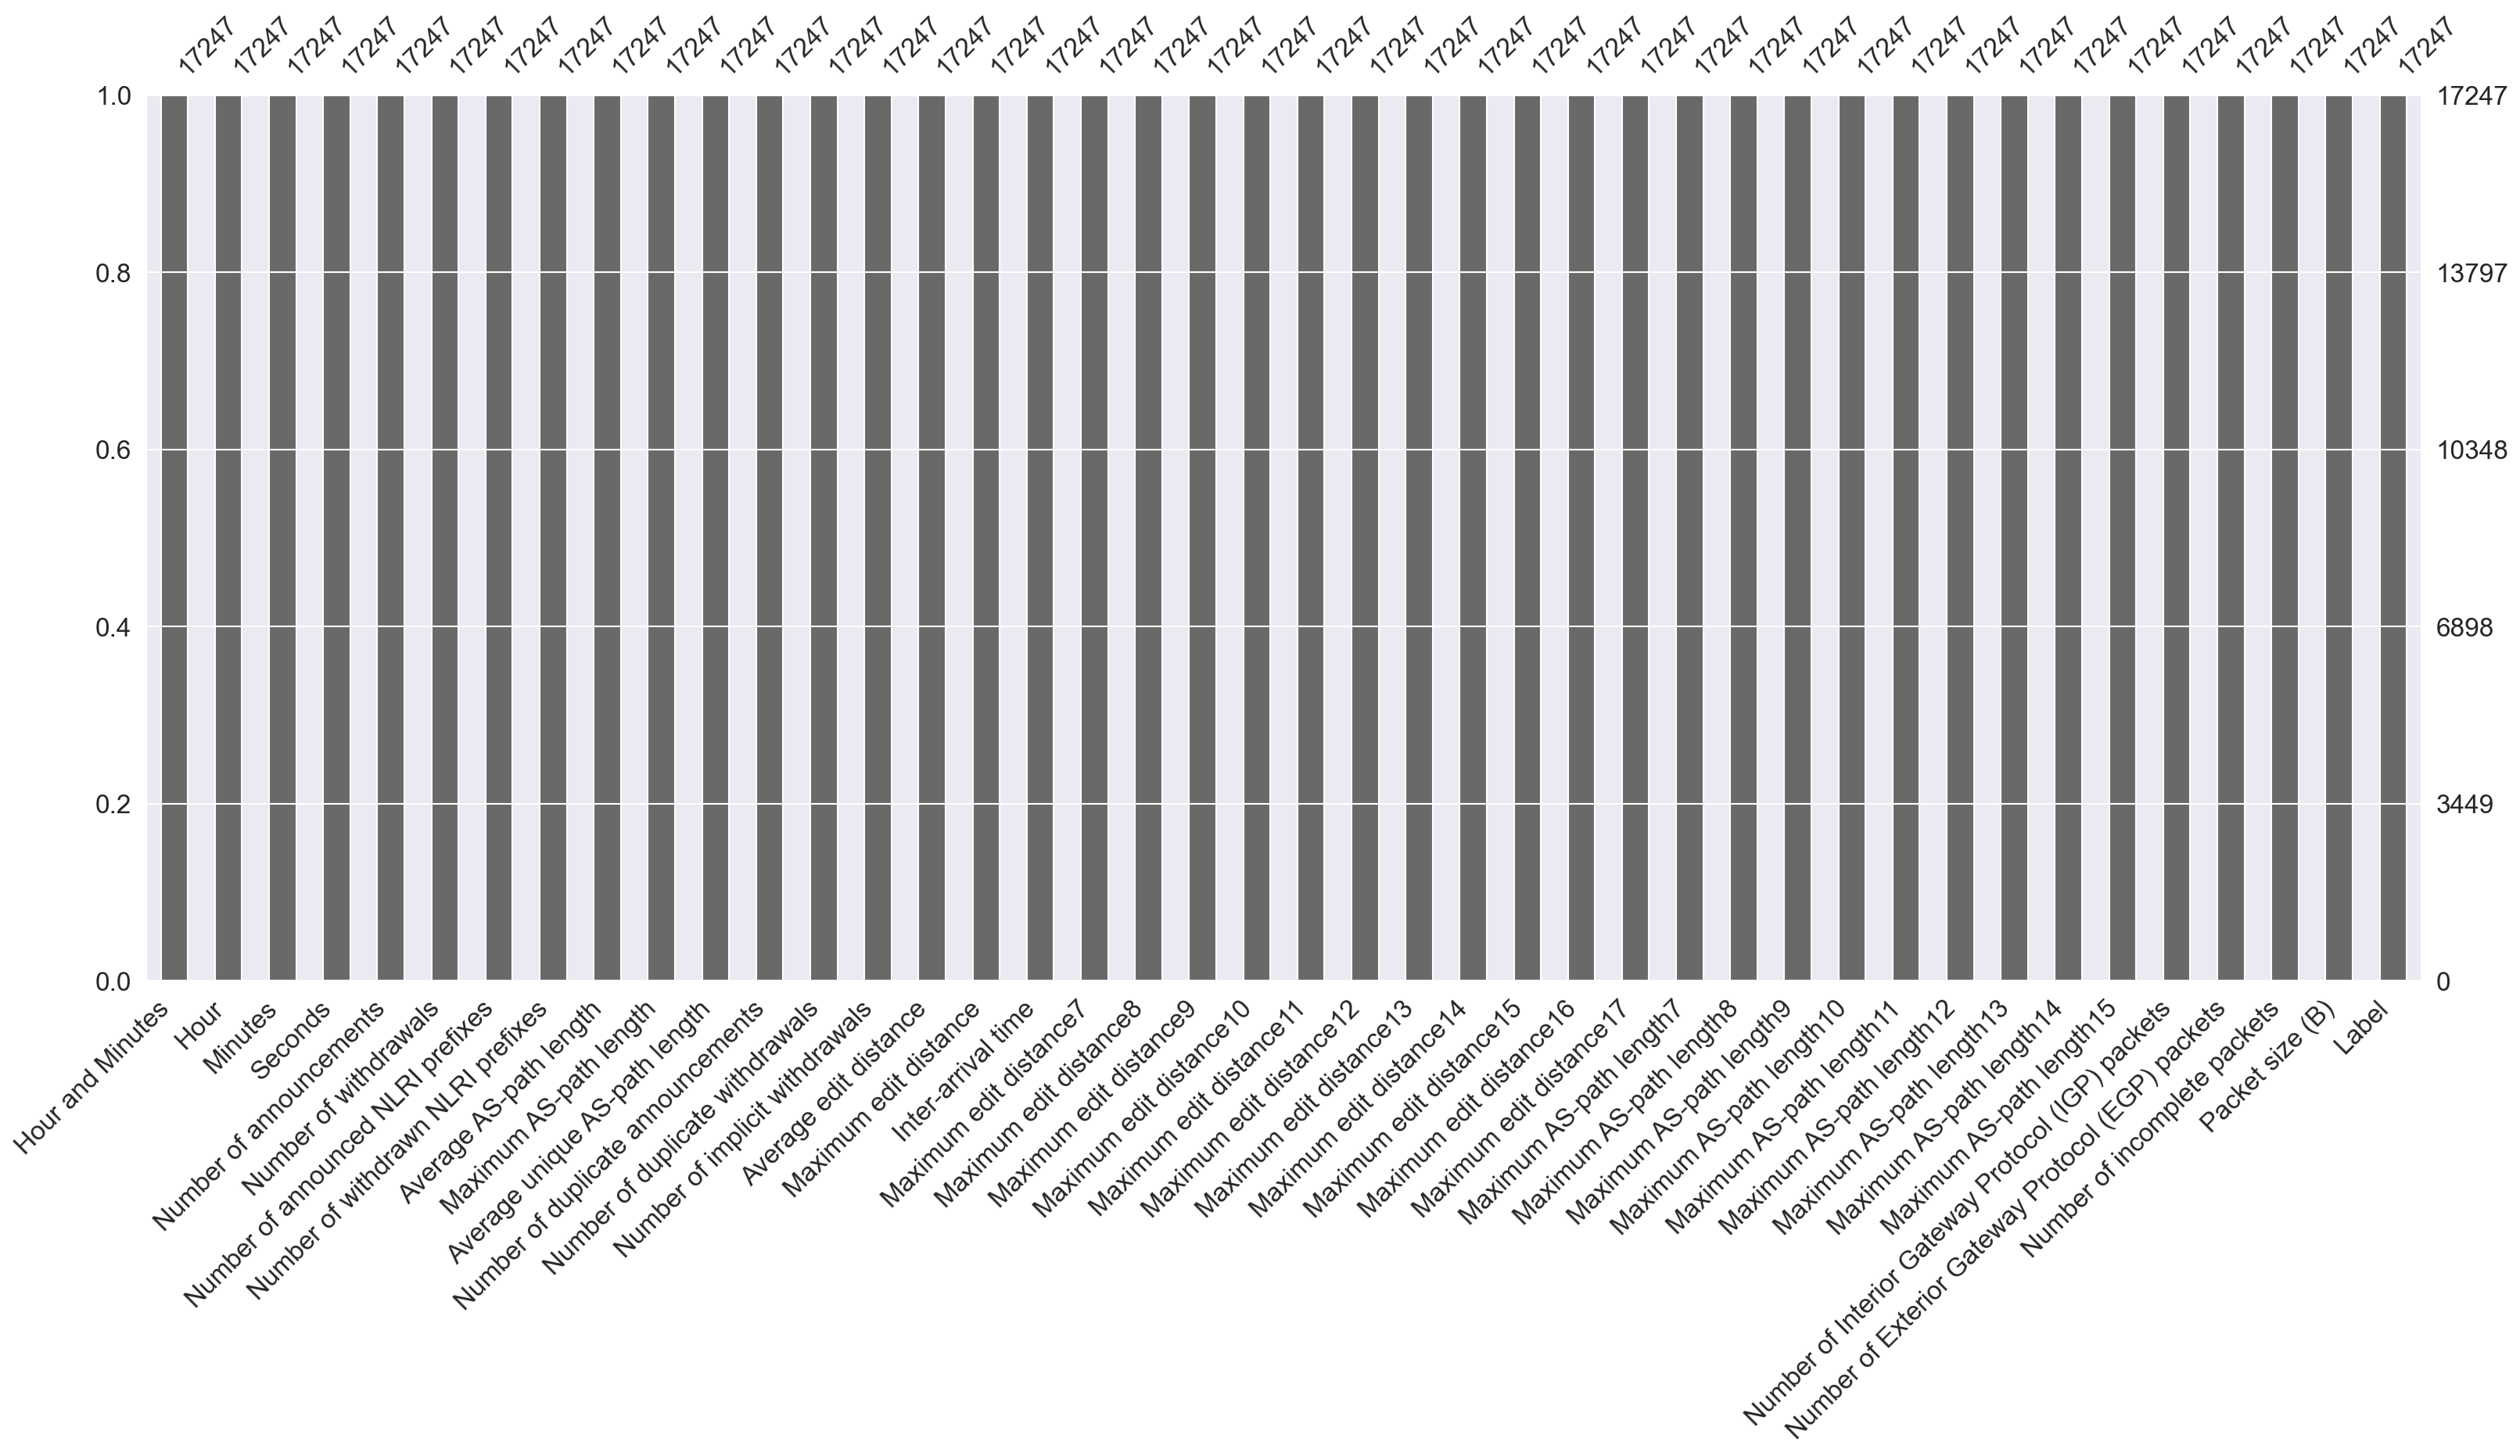

In [17]:
msno.bar(df)

In [18]:
#Checking out the categories and their respective counts in Label feature
print("Job:",df.Label.value_counts(),sep = '\n')

Job:
-1    12882
 1     4365
Name: Label, dtype: int64


### Upscaling Minority class for Balanced dataset

In [19]:
from sklearn.utils import resample

In [20]:
df_minority = df[df.Label==1]
df_majority = df[df.Label==-1]
df_minority_upsampled = resample(df_minority, replace=True, n_samples = 12882, random_state=1)

#### Combining majority and up-scaled minority to create a balanced dataset

In [21]:
dataset1 = pd.concat([df_minority_upsampled, df_majority])
print(dataset1.shape)
dataset1.reset_index(drop=True)

(25764, 42)


Hour and Minutes  Hour  Minutes  Seconds  Number of announcements  \
0                   926     9       26        3                      489   
1                  1726    17       26        4                       57   
2                  1355    13       55        5                      277   
3                  2053    20       53        3                       54   
4                  2305    23        5        7                       90   
...                 ...   ...      ...      ...                      ...   
25759              2355    23       55       12                       41   
25760              2356    23       56        5                       31   
25761              2357    23       57        0                       44   
25762              2358    23       58        4                       65   
25763              2359    23       59       14                       57   

       Number of withdrawals  Number of announced NLRI prefixes  \
0                          7                               1761   
1                          6                                 97   
2                          8                                802   
3                          7                                206   
4                          6                                266   
...                      ...                                ...   
25759                      5                                202   
25760                      3                                286   
25761                      6                                 96   
25762                      4                                170   
25763                      6                                 89   

       Number of withdrawn NLRI prefixes  Average AS-path length  \
0                                    358                       6   
1                                     19                       6   
2                                     52                       6   
3                                    198                       6   
4                                     35                       7   
...                                  ...                     ...   
25759                                 31                       5   
25760                                  5                       6   
25761                                 42                       6   
25762                                 24                       6   
25763                                 24                       6   

       Maximum AS-path length  ...  Maximum AS-path length11  \
0                          16  ...                         0   
1                          10  ...                         0   
2                          15  ...                         0   
3                          10  ...                         0   
4                          22  ...                         0   
...                       ...  ...                       ...   
25759                      10  ...                         0   
25760                       7  ...                         0   
25761                       8  ...                         0   
25762                       9  ...                         0   
25763                       9  ...                         0   

       Maximum AS-path length12  Maximum AS-path length13  \
0                             0                         0   
1                             0                         0   
2                             0                         0   
3                             0                         0   
4                             0                         0   
...                         ...                       ...   
25759                         0                         0   
25760                         0                         0   
25761                         0                         0   
25762                         0                         0   
25763                         0 

In [22]:
# Modified Dataset to figure out correlations
X_train1 = dataset1.drop(dataset1.columns[[0,1,2,3,41]], axis=1)
Y_train1 = dataset1.iloc[:,41]
Y_train1 = [0 if ele>0 else 1 for ele in Y_train1]
Y_train1 = pd.Series(Y_train1)
X_test1 = code_redi_df.drop(code_redi_df.columns[[0,1,2,3,41]], axis=1)
Y_test1 = code_redi_df.iloc[:,41]
Y_test1 = [0 if ele>0 else 1 for ele in Y_test1]
Y_test1 = pd.Series(Y_test1)

In [23]:
X_train1.iloc[:,0]
Y_train1
# X_train1.reset_index(drop=True)

0        0
1        0
2        0
3        0
4        0
        ..
25759    1
25760    1
25761    1
25762    1
25763    1
Length: 25764, dtype: int64

Text(0.5, 1.0, 'Correlation Matrix for all 37 features')

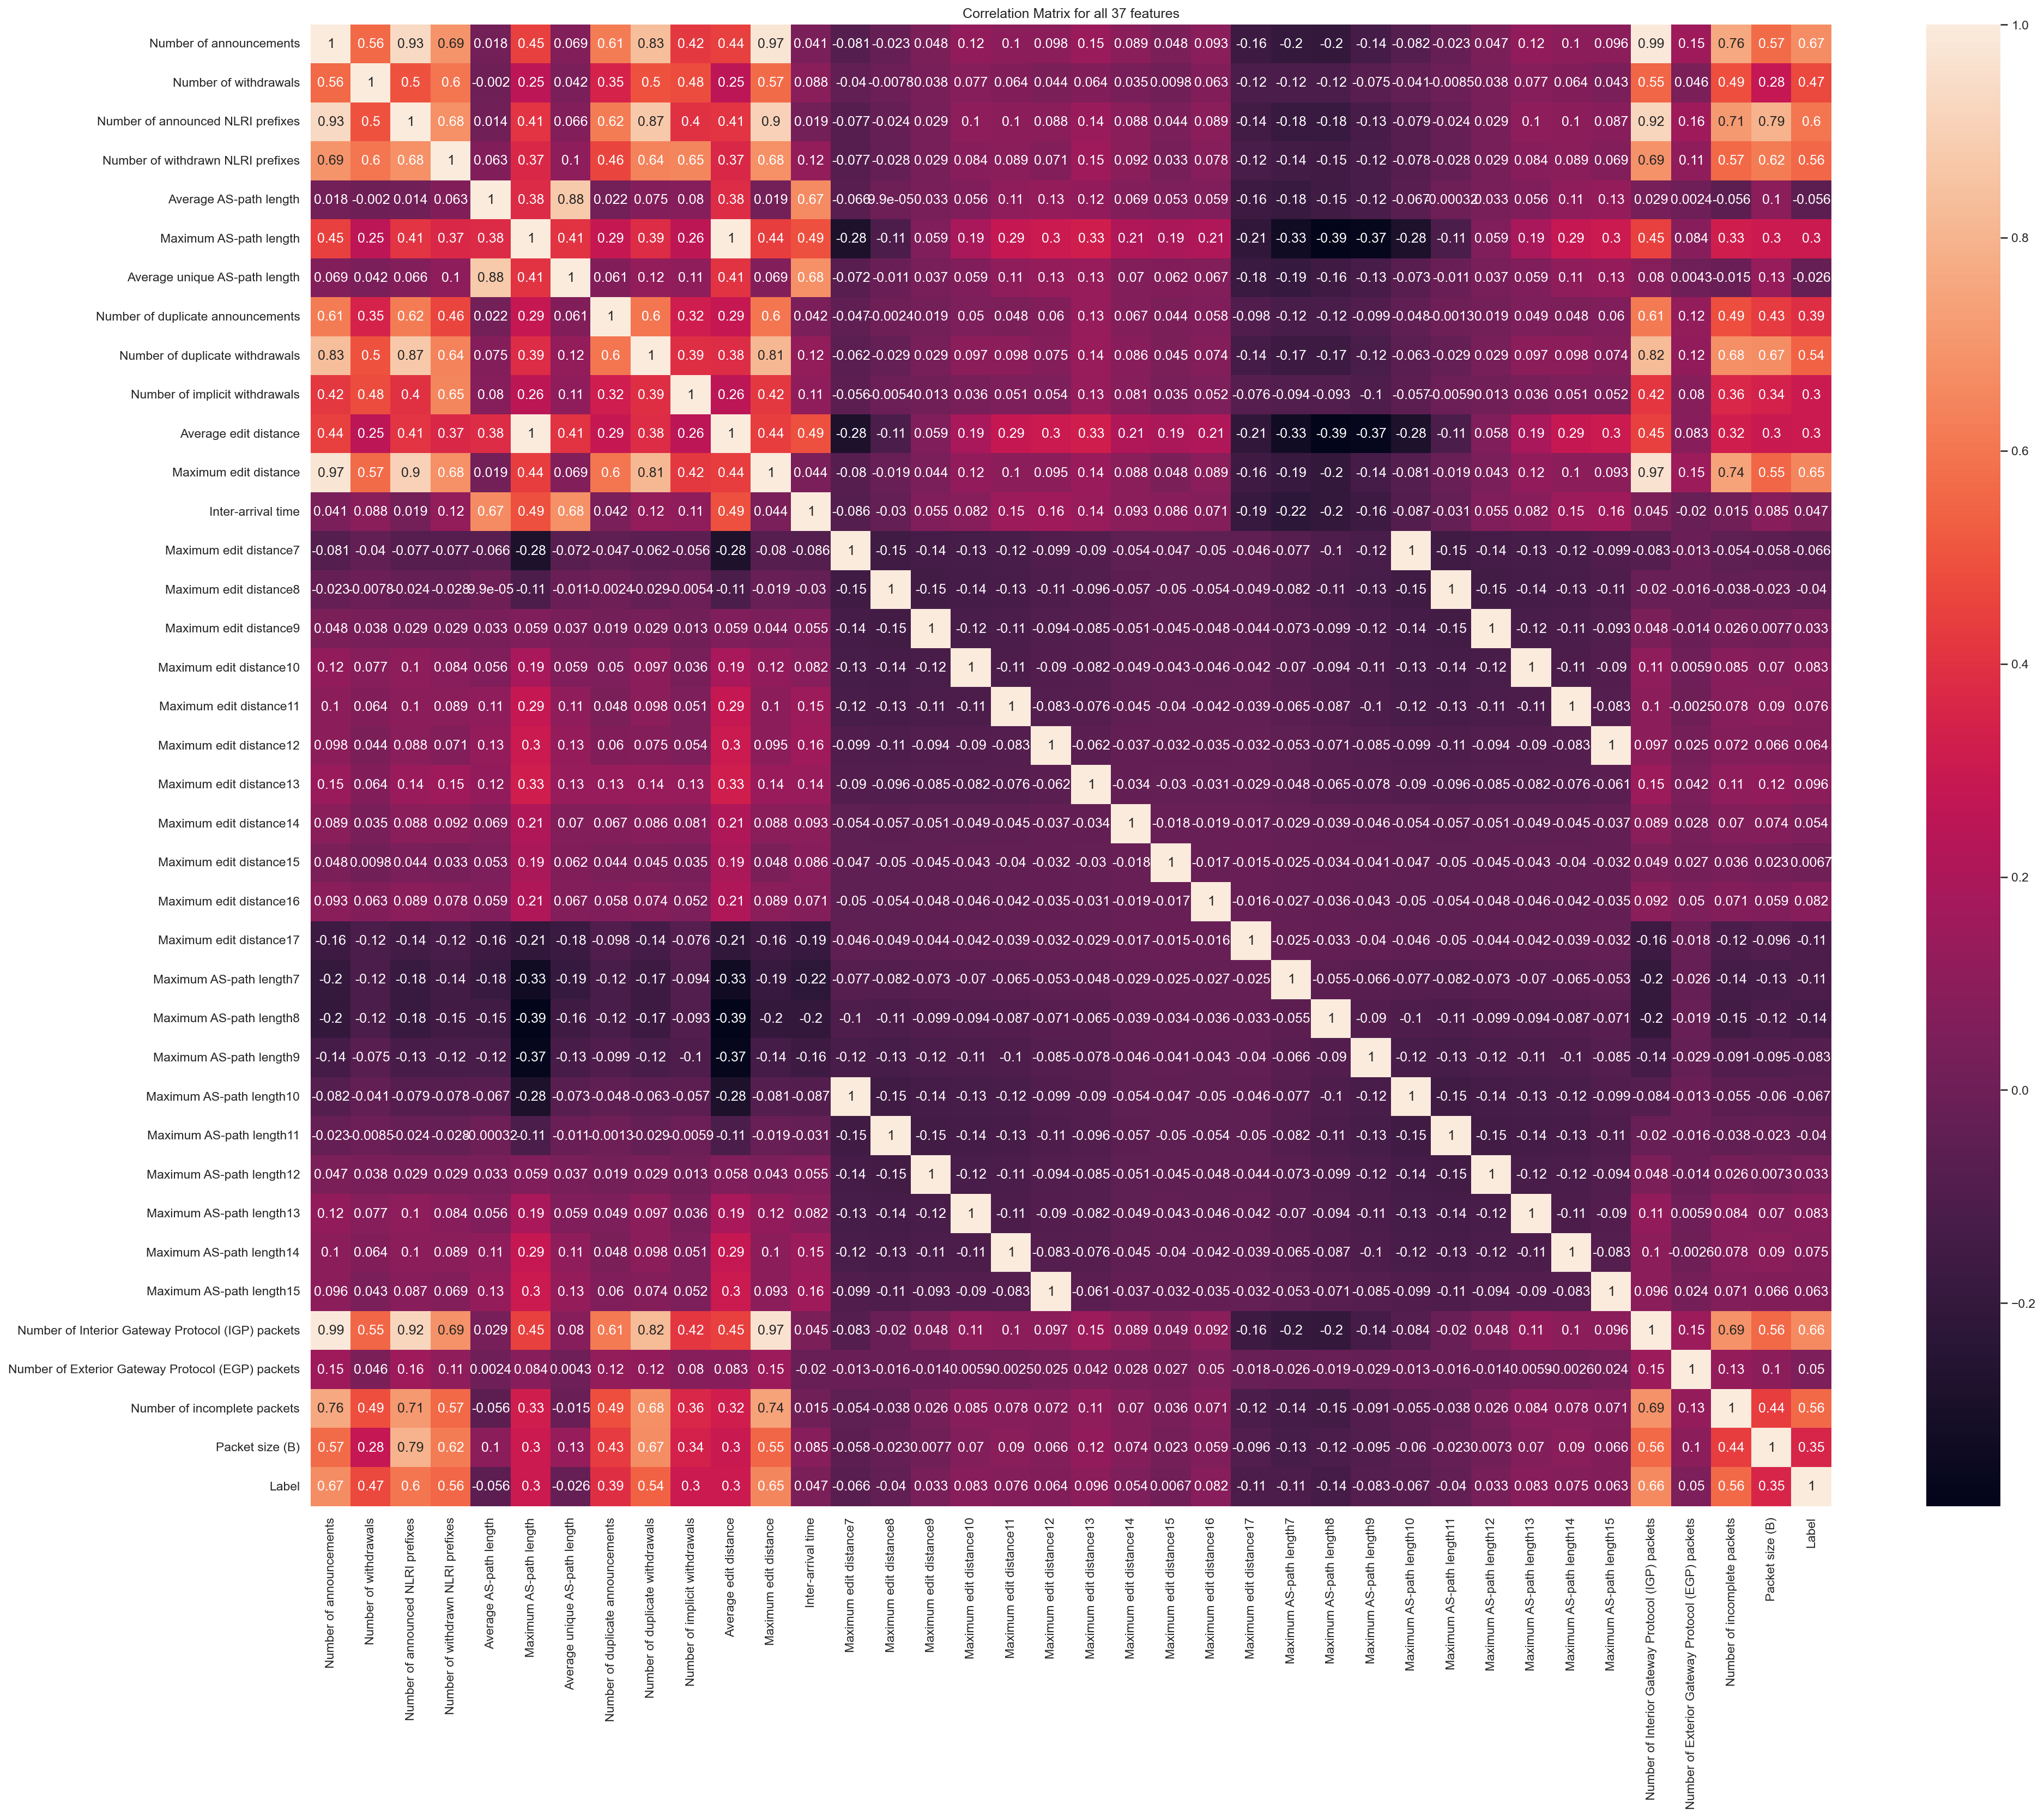

In [24]:
plt.figure(figsize=(30,24))
sns_plot = sns.heatmap(dataset1.iloc[:,4:42].corr(method='spearman'), annot=True)
fig = sns_plot.get_figure()
#fig.savefig("heatmap_corr_spearman.png")
# plt.savefig("Heat_map.png")
plt.title("Correlation Matrix for all 37 features")

Number of Numerical features: 42
Number of Categorical features: 0


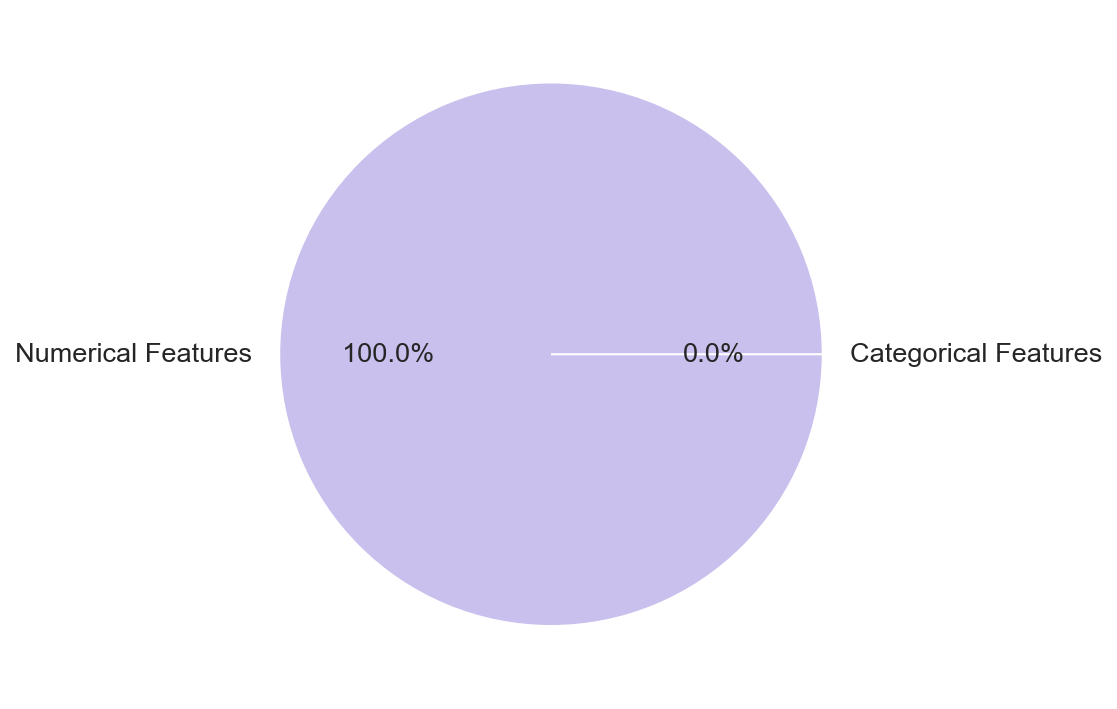

In [25]:
#calculate and plot the distribution of numerical and categorical features 

df_numerical = df.select_dtypes(exclude="object") 
df_categorical = df.select_dtypes(include="object")

print(f'Number of Numerical features: {len(df_numerical.columns)}')
print(f'Number of Categorical features: {len(df_categorical.columns)}')

plt.pie([len(df_numerical.columns), len(df_categorical.columns)], 
        labels=['Numerical Features', 'Categorical Features'],
        colors=['#C9C0EE', '#C0CB9D'],
        textprops={'fontsize': 13},
        autopct='%1.1f%%')
plt.show()

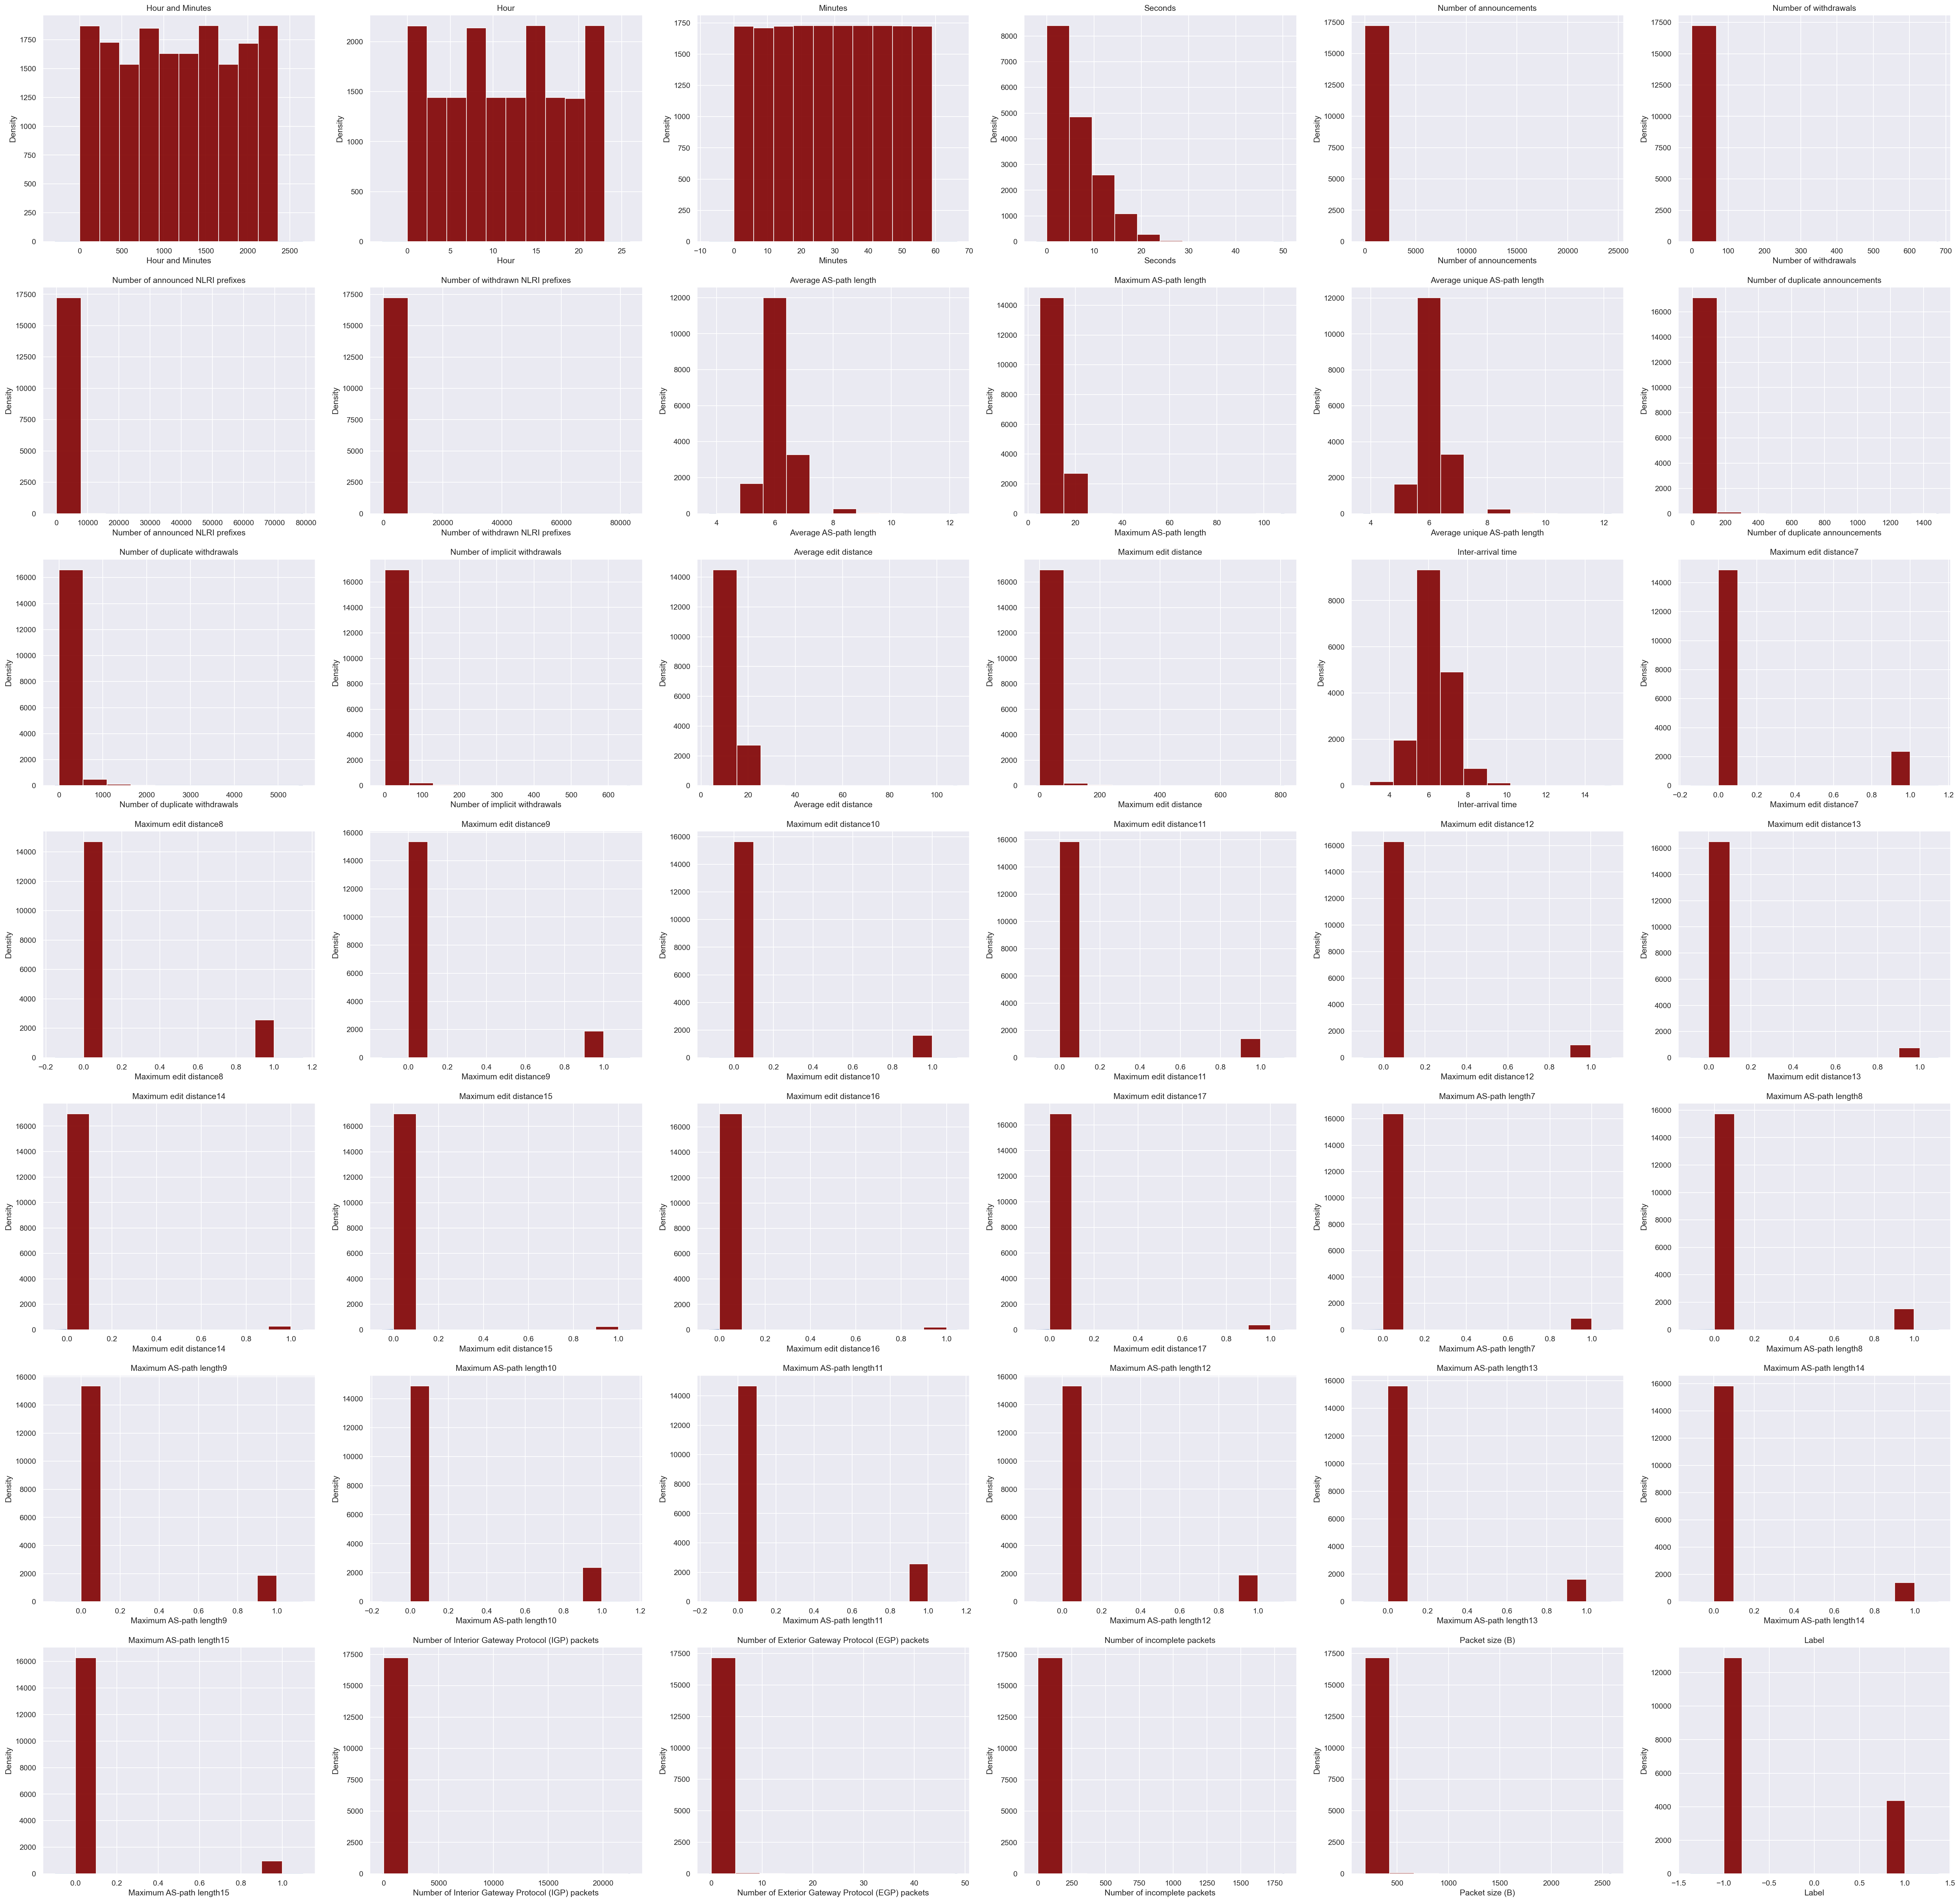

In [26]:
#Visualize distributions of dataset via histograms 

fig = plt.figure(figsize = (50, 50))
for idx, i in enumerate(df_numerical.columns):
    fig.add_subplot(7, 6, idx+1)
    sns.kdeplot(data = df_numerical.iloc[:, idx],
                fill = True)
    df_numerical.iloc[:, idx].hist(bins=10,color='maroon',alpha=0.9)
    plt.subplots_adjust(hspace=0.2)
    plt.title(i)
plt.show()

In [27]:
pos = [9,11,15,38]
colnames = df.columns[pos].tolist()
print (colnames)

['Maximum AS-path length', 'Number of duplicate announcements', 'Maximum edit distance', 'Number of Exterior Gateway Protocol (EGP) packets']


<AxesSubplot:xlabel='Hour', ylabel='Maximum AS-path length'>

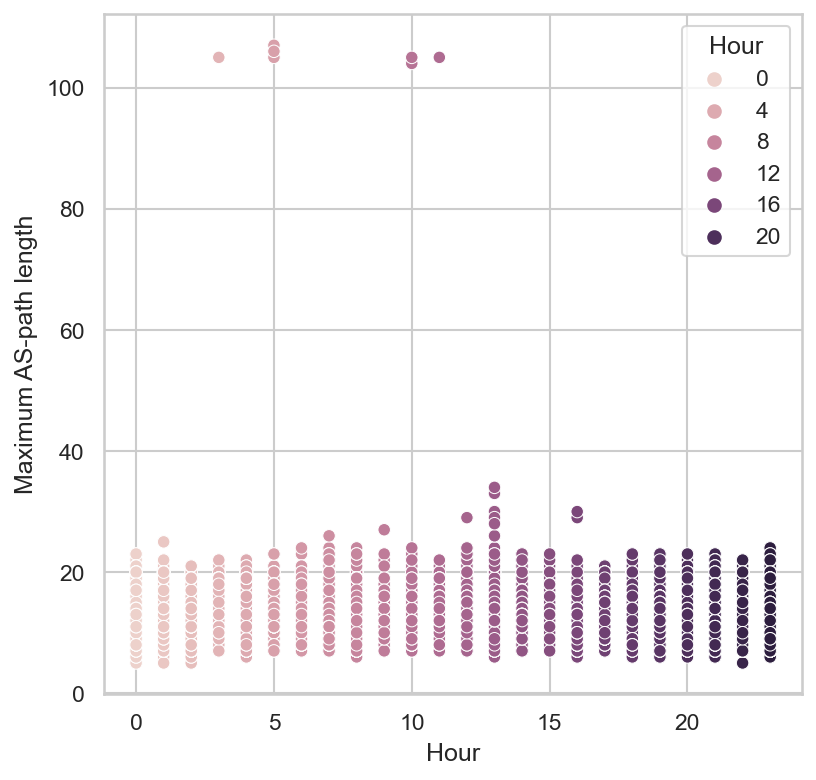

In [28]:
sns.set(style='whitegrid')
sns.scatterplot(x="Hour", y="Maximum AS-path length",data=df, hue='Hour', sizes=(30, 200), legend='brief')

<AxesSubplot:xlabel='Hour', ylabel='Number of Exterior Gateway Protocol (EGP) packets'>

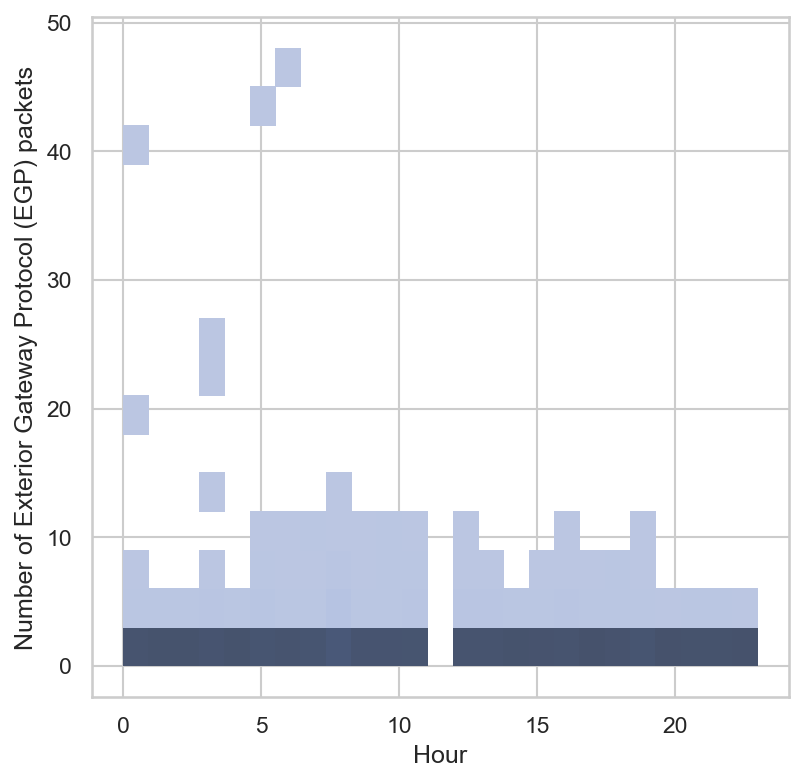

In [29]:
sns.histplot(df,x ="Hour", y ="Number of Exterior Gateway Protocol (EGP) packets", element="poly")

<AxesSubplot:xlabel='Hour', ylabel='Number of duplicate announcements'>

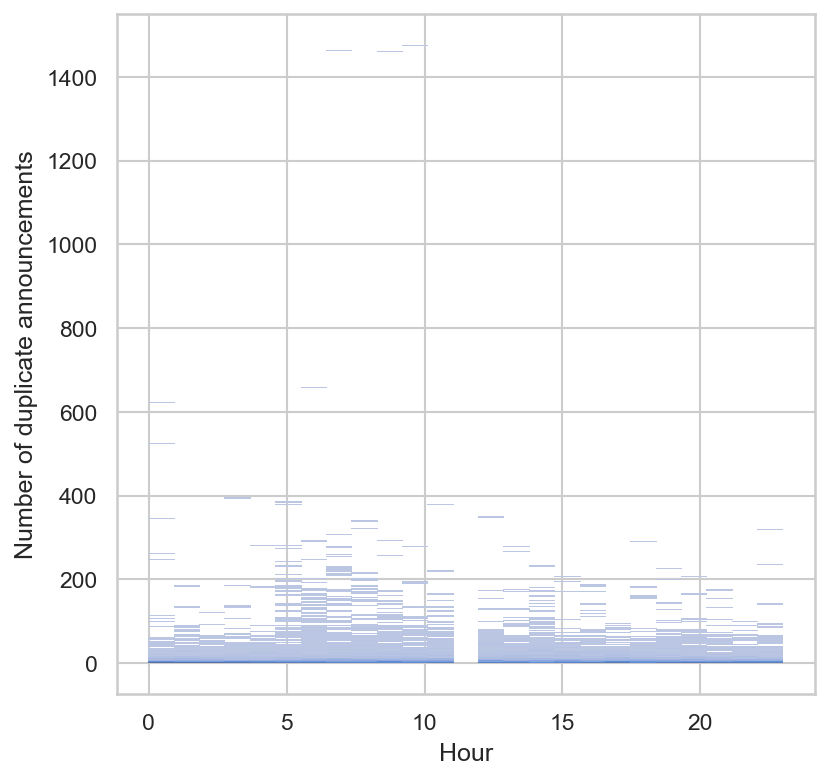

In [30]:
sns.histplot(data=df, x="Hour", y="Number of duplicate announcements", element="step", stat="density", common_norm=False)

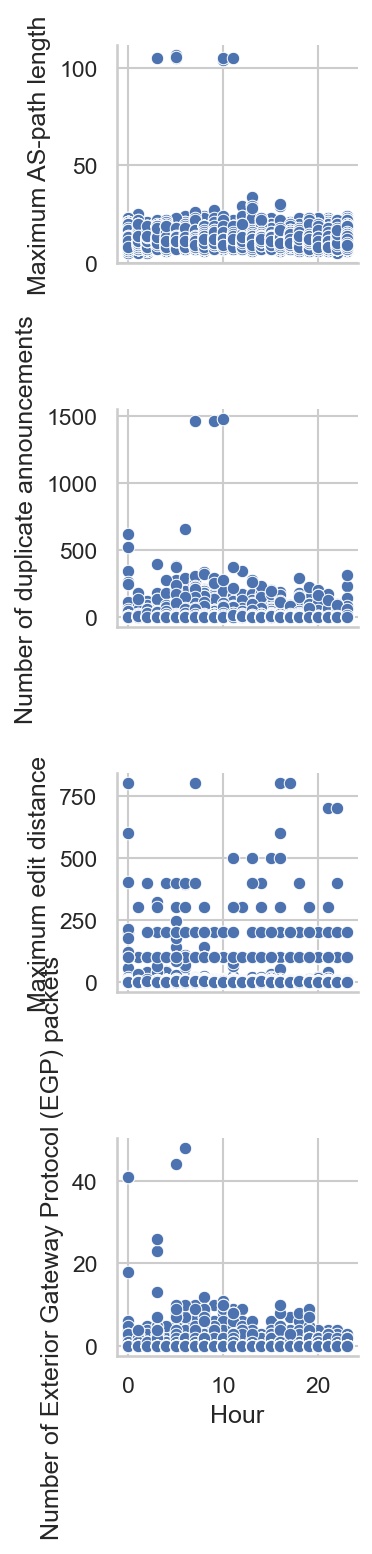

In [31]:
pos = [9,11,15,38]
colnames = df.columns[pos].tolist()

sns.pairplot(
    df,
    x_vars=["Hour"],
    y_vars=colnames,
)

**Method to visualize class imbalance **

In [32]:
# a method to visualize class balance 

def class_balance (hexcolorA, hexcolorB, edgecolor):
    
       
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    target_cnt = df['Label'].value_counts().sort_index()

    ax.bar(target_cnt.index, target_cnt, color=[hexcolorA if i%2==0 else hexcolorB for i in range(9)],
       width=0.30, 
       edgecolor=edgecolor, 
       linewidth=0.5)

    ax.margins(0.02, 0.05)

    #for i in range(2):
    #ax.annotate(f'{target_cnt[i]/len(df)*100:.3}', xy=(i, target_cnt[i]+1000),
                   #va='center', ha='center',
               #)

    ax.set_title('Target Variable Distribution', weight='bold', fontsize=15)
    ax.grid(axis='y', linestyle='-', alpha=0.4)

    fig.tight_layout()
    plt.show()
    return

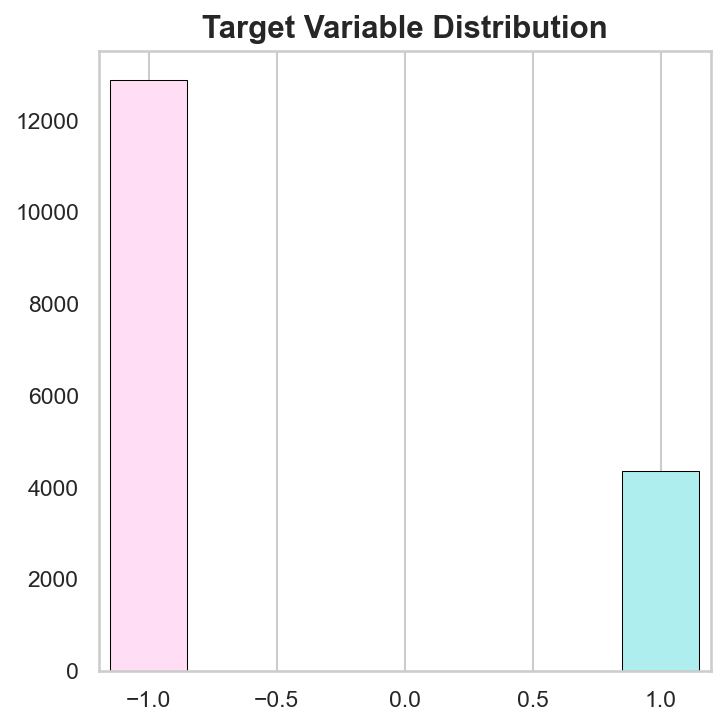

In [33]:
class_balance('#FFDDF4', '#AFEEEE', 'black')

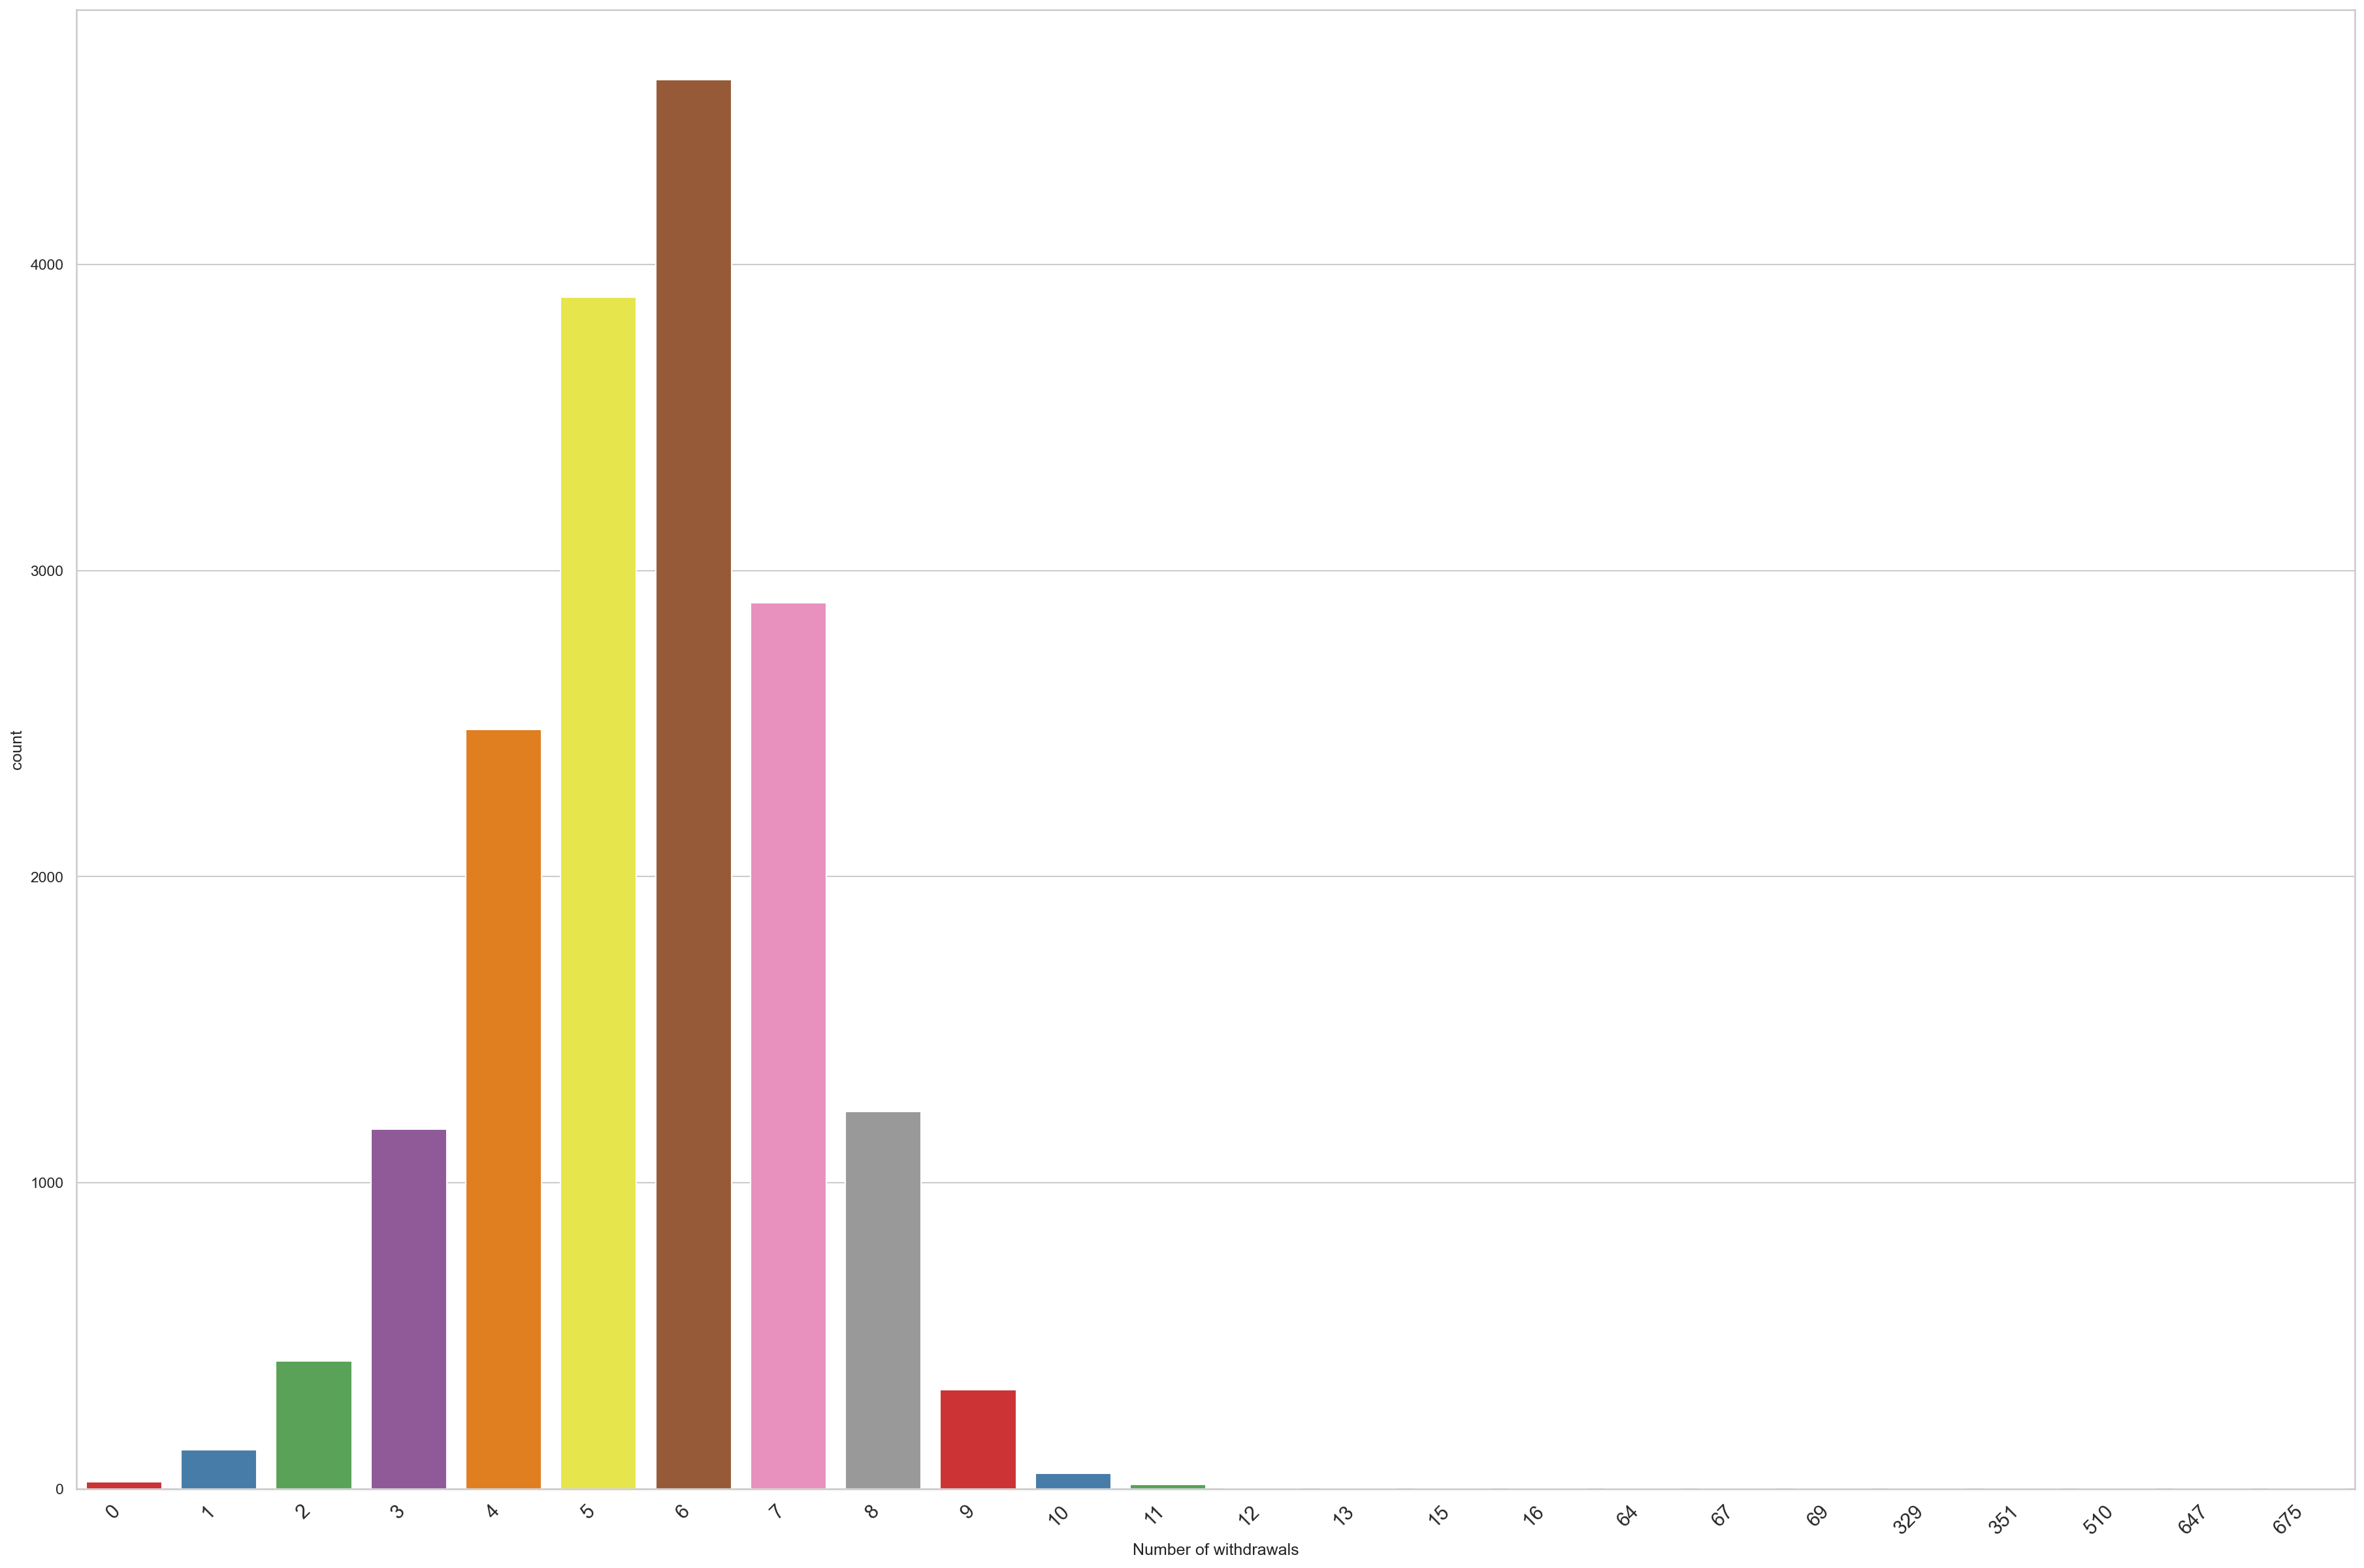

In [34]:
plt.figure(figsize=(30,20))

chart = sns.countplot(
    data=df,
    x='Number of withdrawals',
    palette='Set1'
)

chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light', fontsize='large')

#hide label object values
None

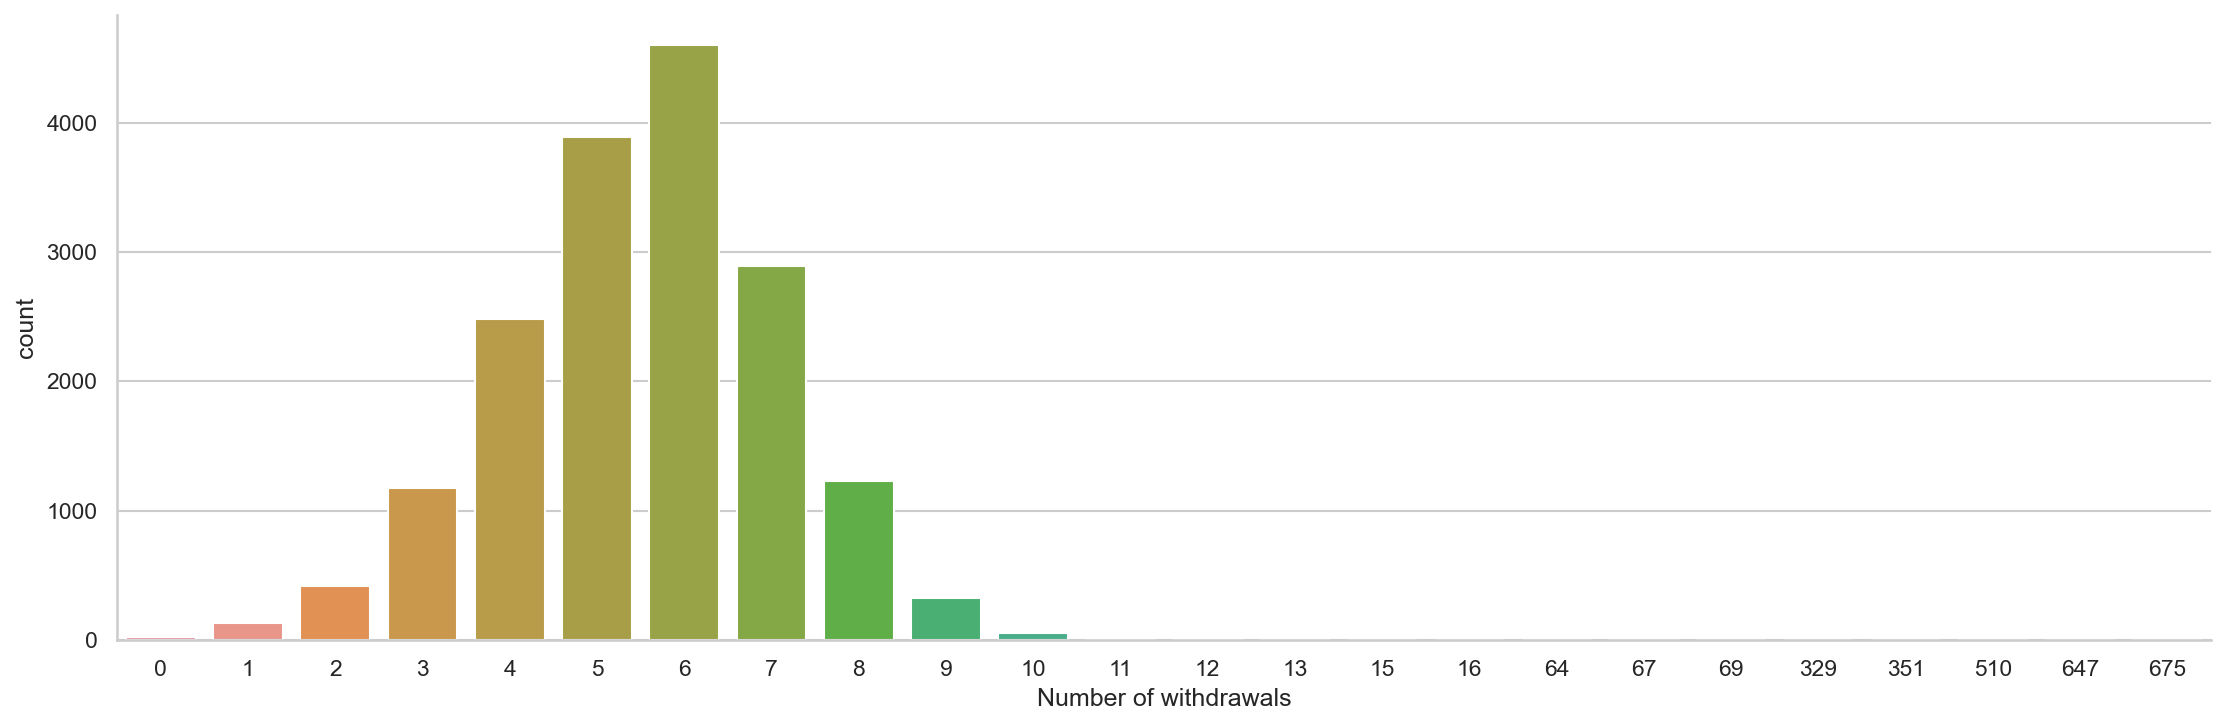

In [35]:
sns.catplot('Number of withdrawals',kind = 'count',data = df,aspect =3)

In [36]:
df_numerical.describe().round().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='viridis')

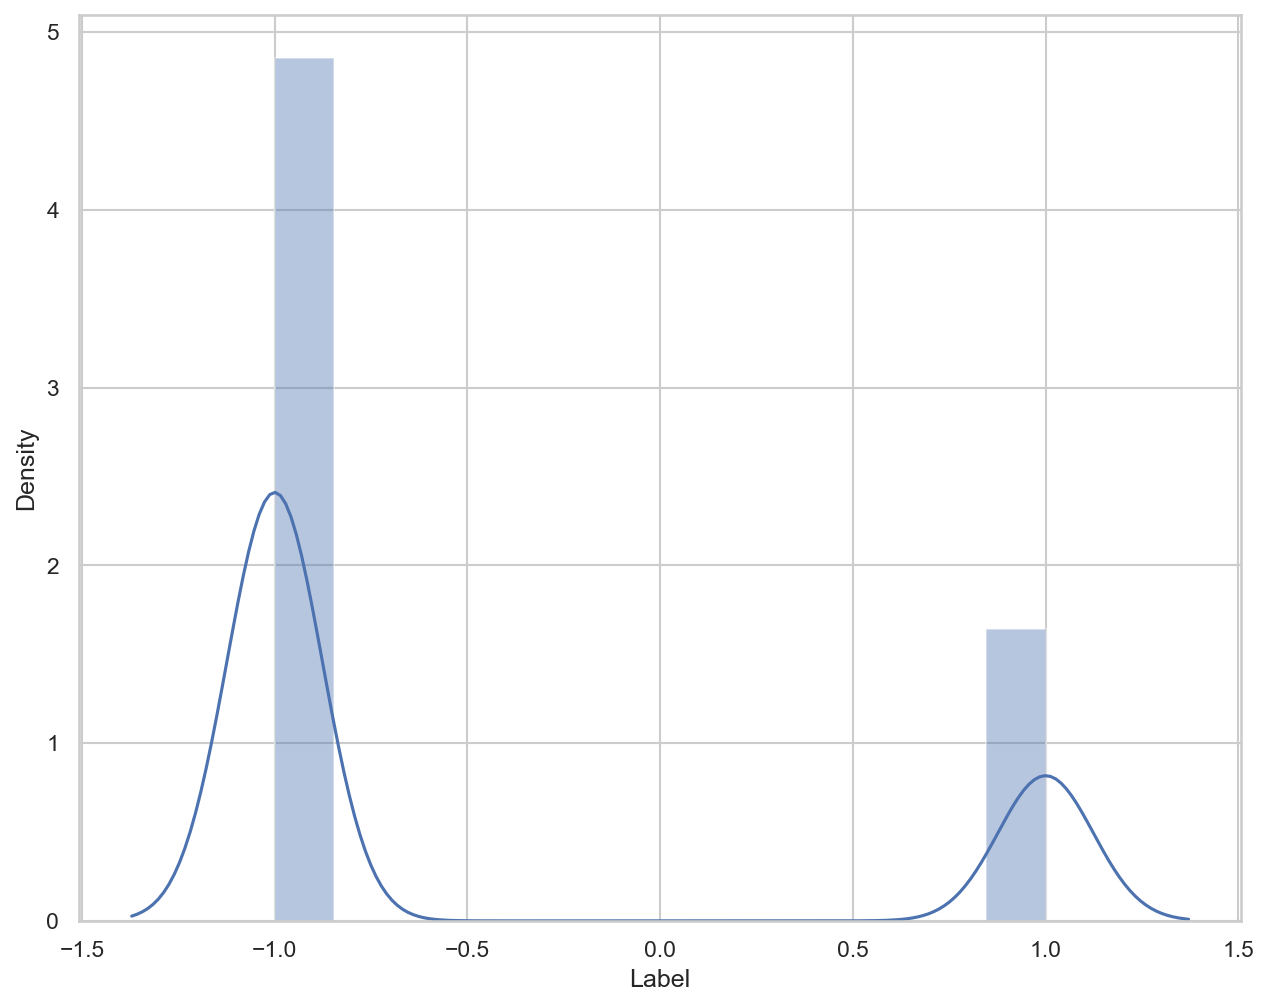

In [37]:
plt.figure(figsize=(10,8))
sns.distplot(df["Label"])
plt.show()

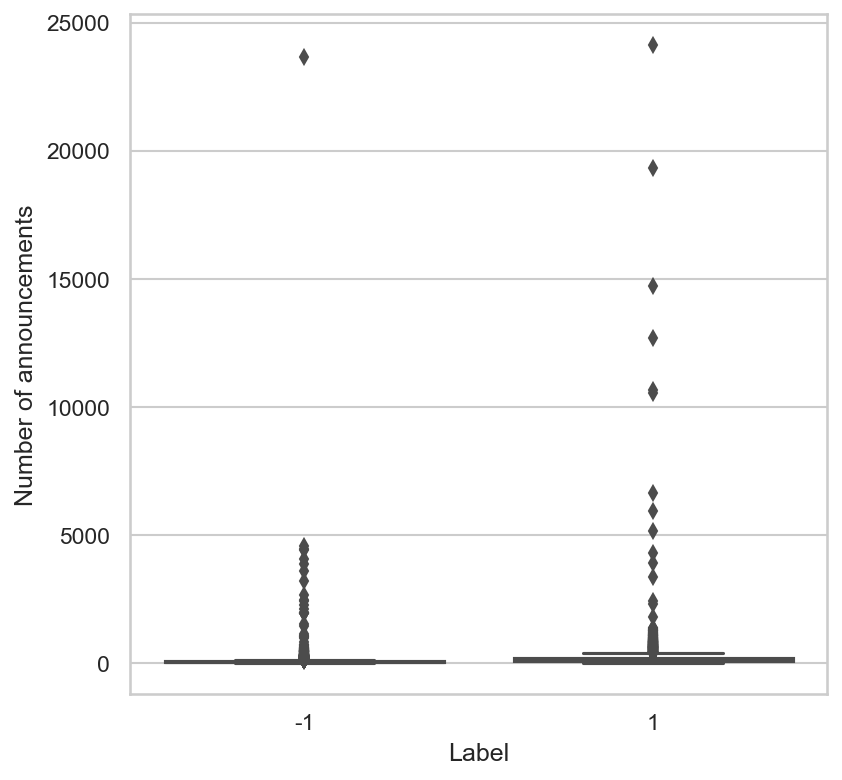

In [38]:
sns.boxplot(data=df, x="Label", y="Number of announcements")
plt.show()

In [39]:
discrete_features = []

for col in df_numerical.columns:
    if np.array_equal(df_numerical[col].values, df_numerical[col].values.astype(int)):
        discrete_features.append(col)

print(f'Total {len(discrete_features)} : ')
print(discrete_features)

Total 41 : 
['Hour and Minutes', 'Hour', 'Minutes', 'Seconds', 'Number of announcements', 'Number of withdrawals', 'Number of announced NLRI prefixes', 'Number of withdrawn NLRI prefixes', 'Average AS-path length', 'Maximum AS-path length', 'Average unique AS-path length', 'Number of duplicate announcements', 'Number of duplicate withdrawals', 'Number of implicit withdrawals', 'Average edit distance', 'Inter-arrival time', 'Maximum edit distance7', 'Maximum edit distance8', 'Maximum edit distance9', 'Maximum edit distance10', 'Maximum edit distance11', 'Maximum edit distance12', 'Maximum edit distance13', 'Maximum edit distance14', 'Maximum edit distance15', 'Maximum edit distance16', 'Maximum edit distance17', 'Maximum AS-path length7', 'Maximum AS-path length8', 'Maximum AS-path length9', 'Maximum AS-path length10', 'Maximum AS-path length11', 'Maximum AS-path length12', 'Maximum AS-path length13', 'Maximum AS-path length14', 'Maximum AS-path length15', 'Number of Interior Gateway Pr

In [40]:
print(f'Unique values as follows:-')
for dcol in discrete_features:
    print(f'{dcol}: {df_numerical[dcol].nunique()}')

Unique values as follows:-
Hour and Minutes: 1440
Hour: 24
Minutes: 60
Seconds: 29
Number of announcements: 694
Number of withdrawals: 24
Number of announced NLRI prefixes: 1496
Number of withdrawn NLRI prefixes: 492
Average AS-path length: 8
Maximum AS-path length: 32
Average unique AS-path length: 9
Number of duplicate announcements: 223
Number of duplicate withdrawals: 985
Number of implicit withdrawals: 173
Average edit distance: 32
Inter-arrival time: 11
Maximum edit distance7: 2
Maximum edit distance8: 2
Maximum edit distance9: 2
Maximum edit distance10: 2
Maximum edit distance11: 2
Maximum edit distance12: 2
Maximum edit distance13: 2
Maximum edit distance14: 2
Maximum edit distance15: 2
Maximum edit distance16: 2
Maximum edit distance17: 2
Maximum AS-path length7: 2
Maximum AS-path length8: 2
Maximum AS-path length9: 2
Maximum AS-path length10: 2
Maximum AS-path length11: 2
Maximum AS-path length12: 2
Maximum AS-path length13: 2
Maximum AS-path length14: 2
Maximum AS-path lengt

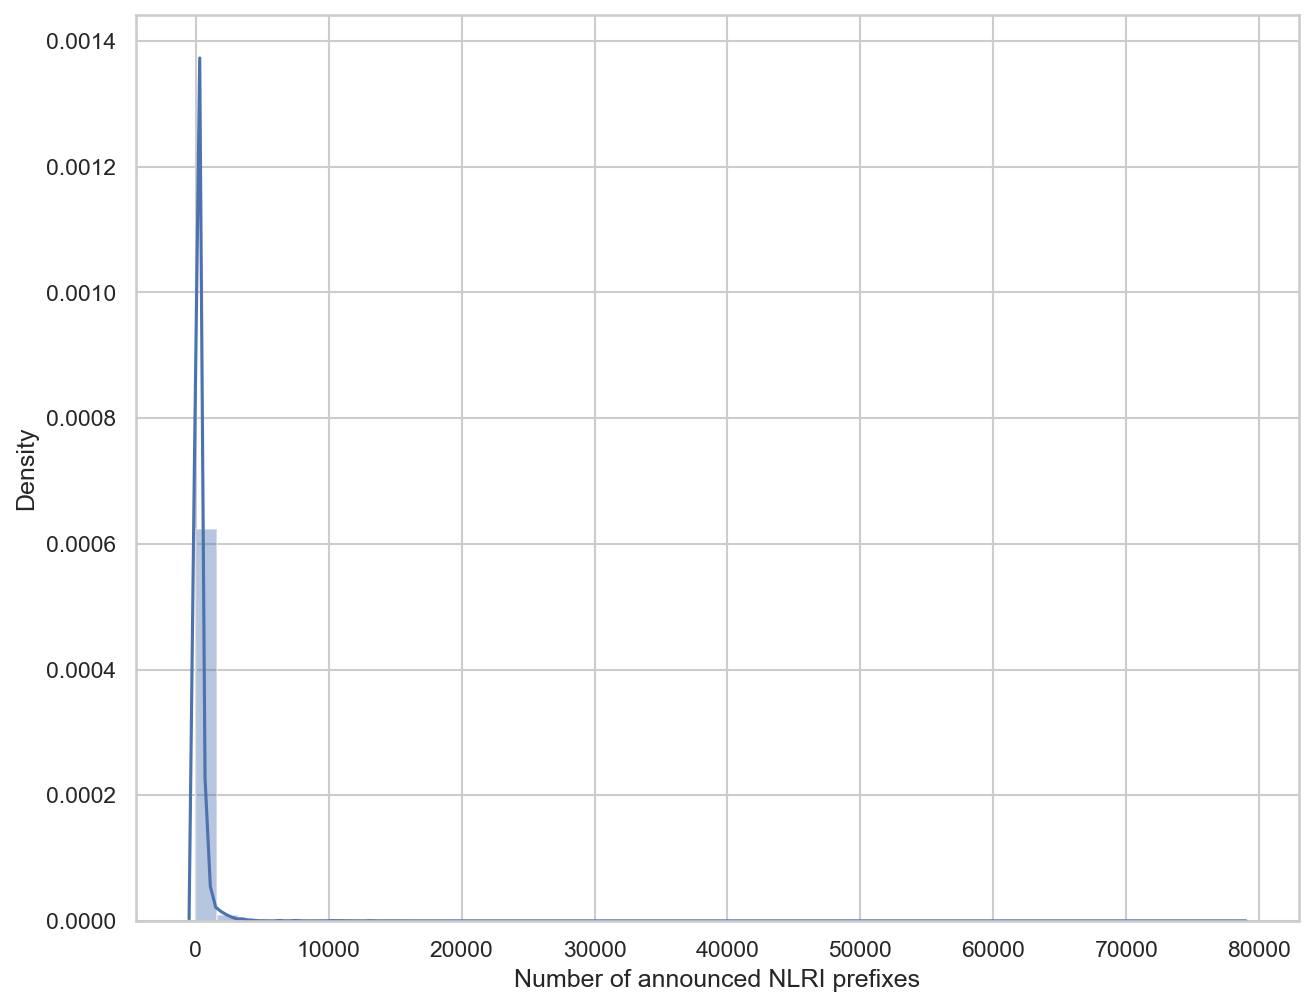

In [41]:
plt.figure(figsize=(10,8))
sns.distplot(df["Number of announced NLRI prefixes"])
plt.show()

<AxesSubplot:>

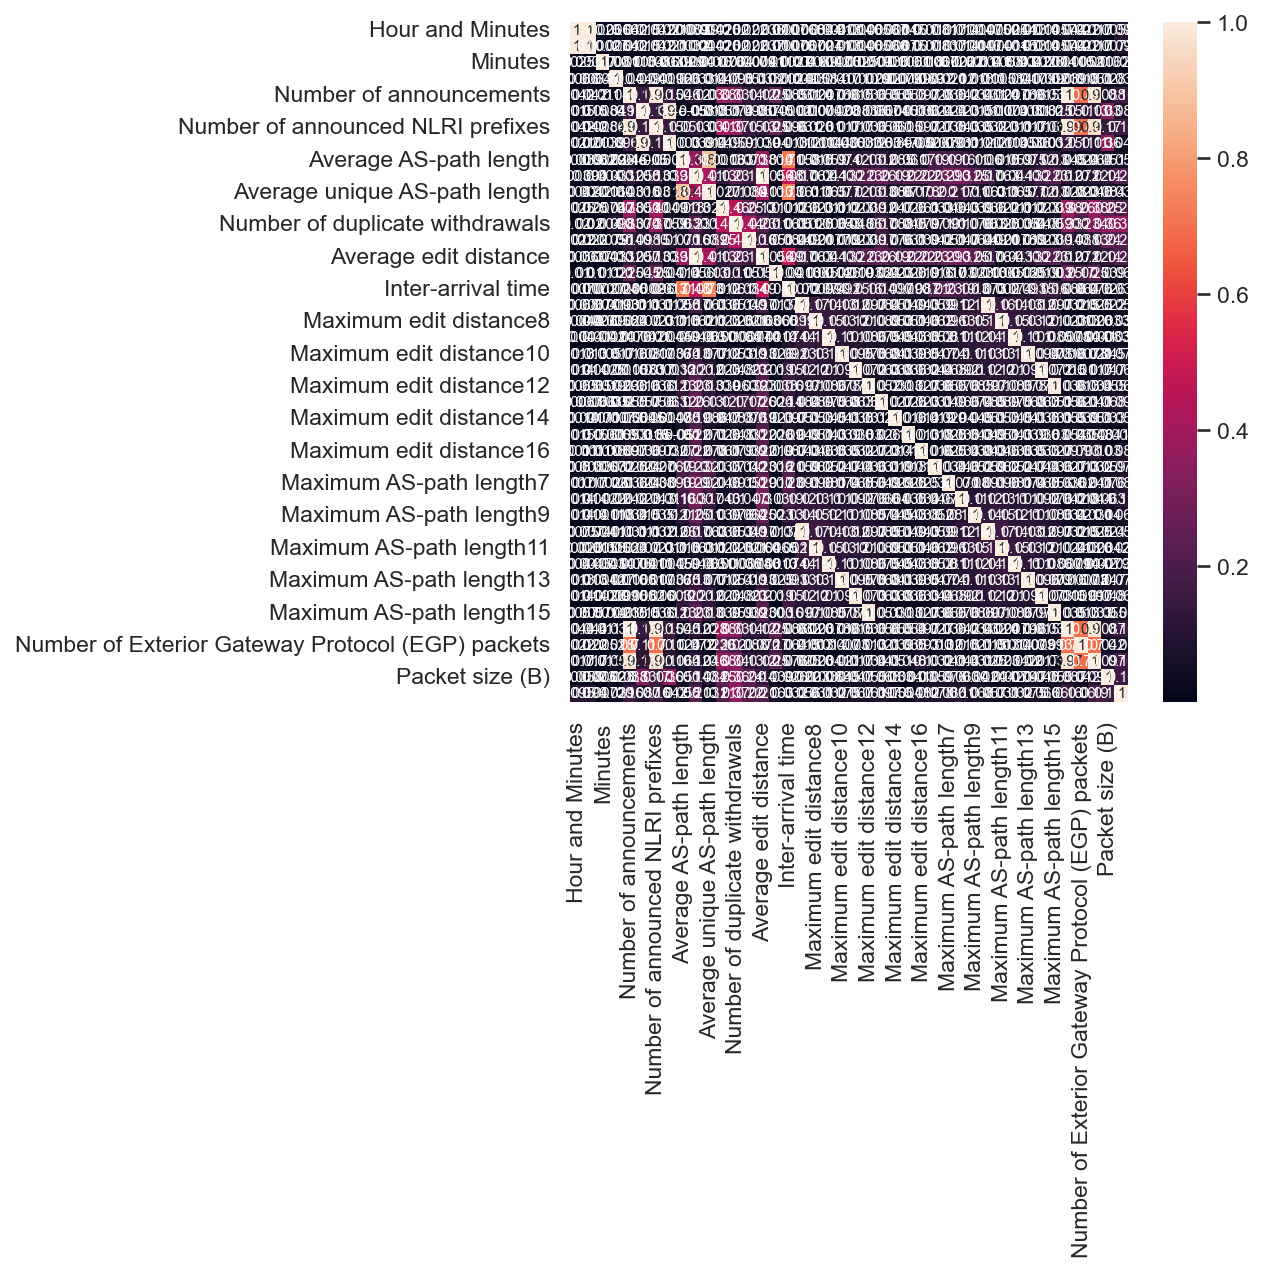

In [42]:
cor_matrix = df_numerical.corr().abs()
sns.heatmap(cor_matrix , annot= True,annot_kws={"size": 7})

<AxesSubplot:>

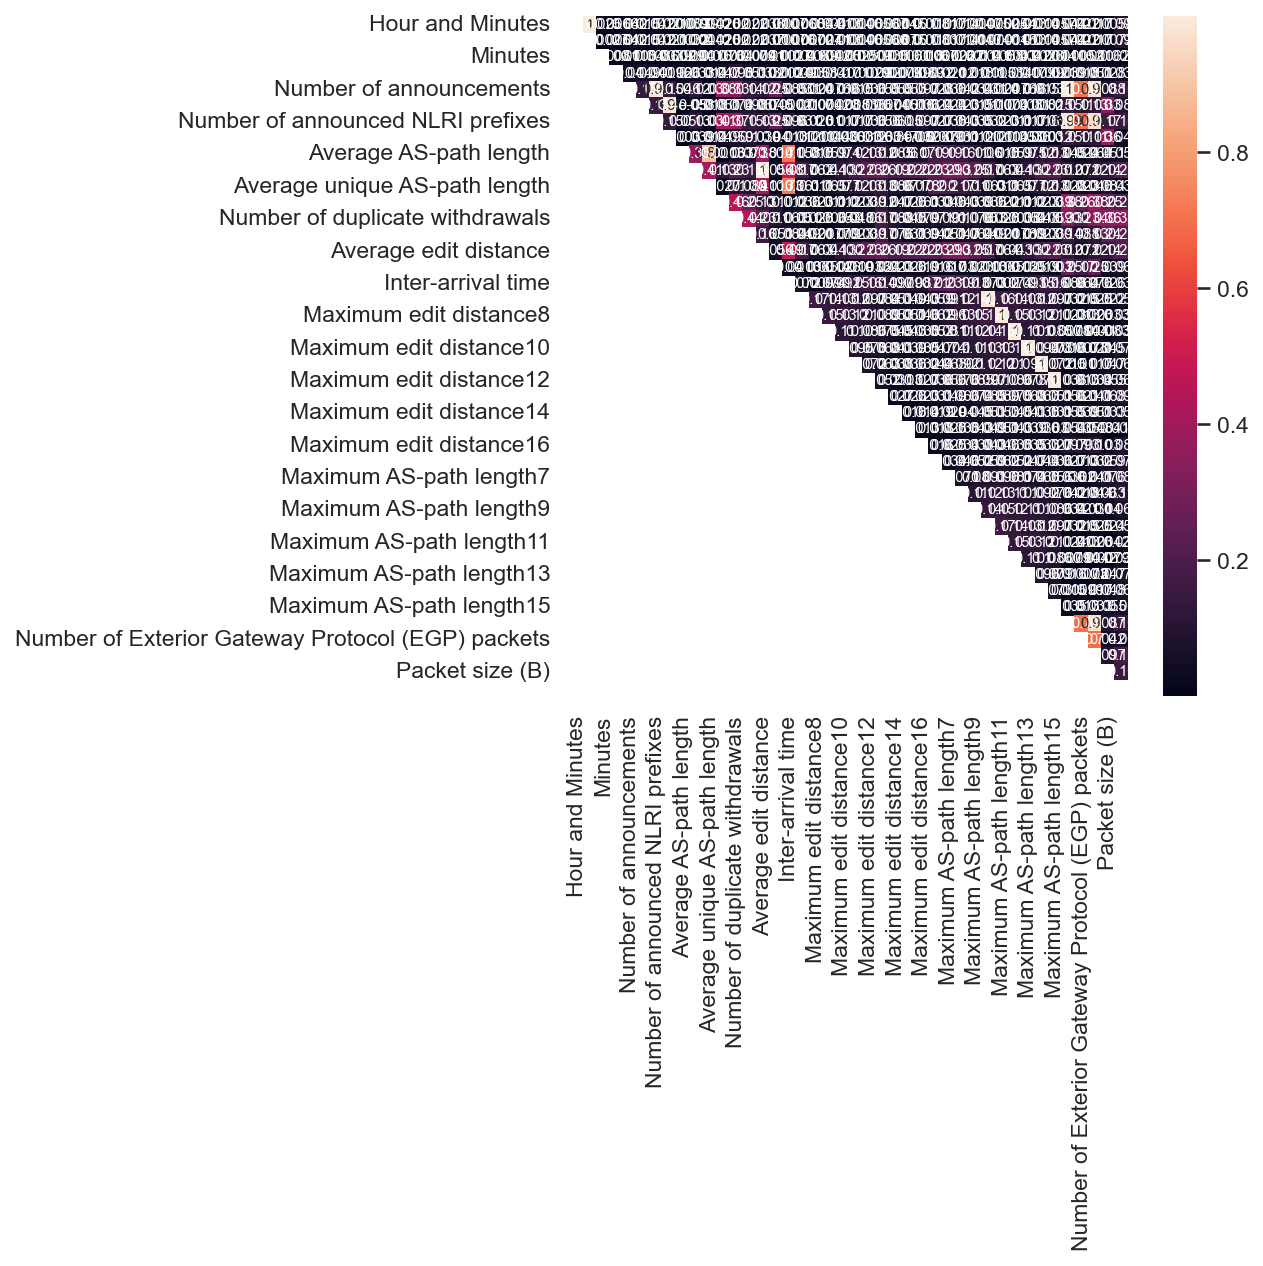

In [43]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
sns.heatmap(upper_tri , annot= True,annot_kws={"size": 7})

In [44]:
#check for highly correlated columns

corr = df.corr()
corr_greater_than_75 = corr[corr>=.75]
corr_greater_than_75

Hour and Minutes      Hour  \
Hour and Minutes                                           1.000000  0.999688   
Hour                                                       0.999688  1.000000   
Minutes                                                         NaN       NaN   
Seconds                                                         NaN       NaN   
Number of announcements                                         NaN       NaN   
Number of withdrawals                                           NaN       NaN   
Number of announced NLRI prefixes                               NaN       NaN   
Number of withdrawn NLRI prefixes                               NaN       NaN   
Average AS-path length                                          NaN       NaN   
Maximum AS-path length                                          NaN       NaN   
Average unique AS-path length                                   NaN       NaN   
Number of duplicate announcements                               NaN       NaN   
Number of duplicate withdrawals                                 NaN       NaN   
Number of implicit withdrawals                                  NaN       NaN   
Average edit distance                                           NaN       NaN   
Maximum edit distance                                           NaN       NaN   
Inter-arrival time                                              NaN       NaN   
Maximum edit distance7                                          NaN       NaN   
Maximum edit distance8                                          NaN       NaN   
Maximum edit distance9                                          NaN       NaN   
Maximum edit distance10                                         NaN       NaN   
Maximum edit distance11                                         NaN       NaN   
Maximum edit distance12                                         NaN       NaN   
Maximum edit distance13                                         NaN       NaN   
Maximum edit distance14                                         NaN       NaN   
Maximum edit distance15                                         NaN       NaN   
Maximum edit distance16                                         NaN       NaN   
Maximum edit distance17                                         NaN       NaN   
Maximum AS-path length7                                         NaN       NaN   
Maximum AS-path length8                                         NaN       NaN   
Maximum AS-path length9                                         NaN       NaN   
Maximum AS-path length10                                        NaN       NaN   
Maximum AS-path length11                                        NaN       NaN   
Maximum AS-path length12                                        NaN       NaN   
Maximum AS-path length13                                        NaN       NaN   
Maximum AS-path length14                                        NaN       NaN   
Maximum AS-path length15                                        NaN       NaN   
Number of Interior Gateway Protocol (IGP) packets               NaN       NaN   
Number of Exterior Gateway Protocol (EGP) packets               NaN       NaN   
Number of incomplete packets                                    NaN       NaN   
Packet size (B)                                                 NaN       NaN   
Label                                                           NaN       NaN   

                                                   Minutes  Seconds  \
Hour and Minutes                                       NaN      NaN   
Hour                                                   NaN      NaN   
Minutes                                                1.0      NaN   
Seconds                                                NaN      1.0   
Number of announcements                                NaN      NaN   
Number of withdrawals                                  NaN      NaN   
Number of announced NLRI prefixes                      NaN      NaN   

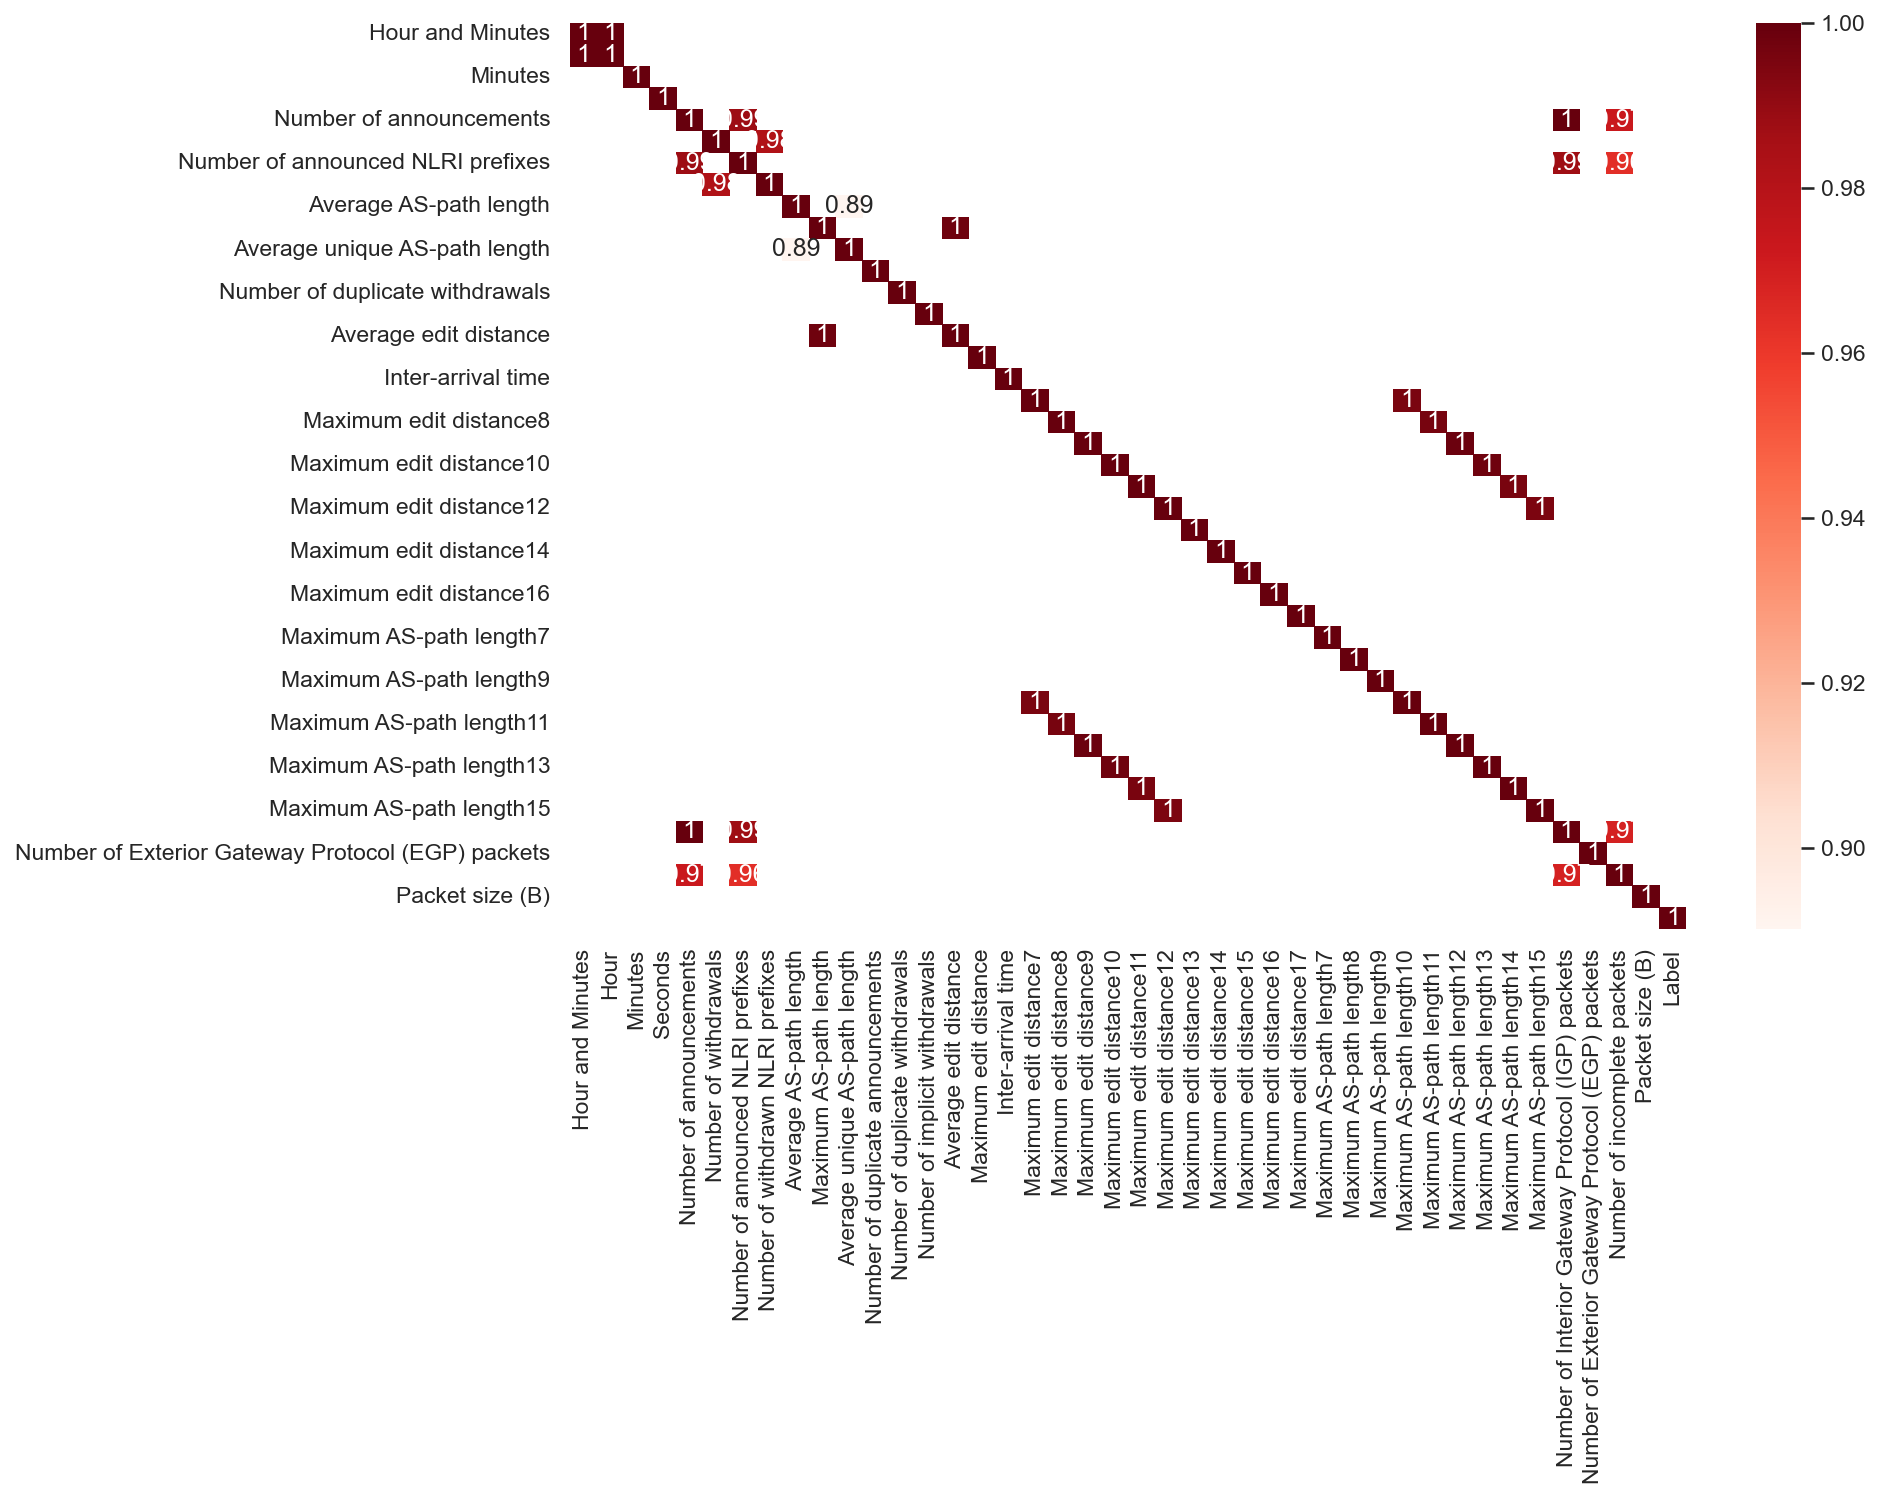

In [45]:

#plot it in a heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_greater_than_75, cmap="Reds", annot = True);

In [46]:
df_duplicate = df[df.duplicated(keep="last")]
df_duplicate

Empty DataFrame
Columns: [Hour and Minutes, Hour, Minutes, Seconds, Number of announcements, Number of withdrawals, Number of announced NLRI prefixes, Number of withdrawn NLRI prefixes, Average AS-path length, Maximum AS-path length, Average unique AS-path length, Number of duplicate announcements, Number of duplicate withdrawals, Number of implicit withdrawals, Average edit distance, Maximum edit distance, Inter-arrival time, Maximum edit distance7, Maximum edit distance8, Maximum edit distance9, Maximum edit distance10, Maximum edit distance11, Maximum edit distance12, Maximum edit distance13, Maximum edit distance14, Maximum edit distance15, Maximum edit distance16, Maximum edit distance17, Maximum AS-path length7, Maximum AS-path length8, Maximum AS-path length9, Maximum AS-path length10, Maximum AS-path length11, Maximum AS-path length12, Maximum AS-path length13, Maximum AS-path length14, Maximum AS-path length15, Number of Interior Gateway Protocol (IGP) packets, Number of Exterior Gateway Protocol (EGP) packets, Number of incomplete packets, Packet size (B), Label]
Index: []

[0 rows x 42 columns]

In [47]:
df_duplicate.shape

(0, 42)

In [48]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
print(to_drop)

['Hour', 'Number of announced NLRI prefixes', 'Number of withdrawn NLRI prefixes', 'Average edit distance', 'Maximum AS-path length10', 'Maximum AS-path length11', 'Maximum AS-path length12', 'Maximum AS-path length13', 'Maximum AS-path length14', 'Maximum AS-path length15', 'Number of Interior Gateway Protocol (IGP) packets', 'Number of incomplete packets']


In [49]:
#deal with missing values

for column in df.columns:
    df[column].replace('unknown', np.nan, inplace=True)
    df.dropna(inplace=True)

In [50]:
df.reset_index(inplace=True,drop=True)
df

Hour and Minutes  Hour  Minutes  Seconds  Number of announcements  \
0                     1     0        1        4                       40   
1                     2     0        2        0                       59   
2                     3     0        3       12                       52   
3                     4     0        4        9                       49   
4                     5     0        5        4                       80   
...                 ...   ...      ...      ...                      ...   
17242              2355    23       55       12                       41   
17243              2356    23       56        5                       31   
17244              2357    23       57        0                       44   
17245              2358    23       58        4                       65   
17246              2359    23       59       14                       57   

       Number of withdrawals  Number of announced NLRI prefixes  \
0                          4                                161   
1                          7                                133   
2                          4                                138   
3                          2                                119   
4                          3                                231   
...                      ...                                ...   
17242                      5                                202   
17243                      3                                286   
17244                      6                                 96   
17245                      4                                170   
17246                      6                                 89   

       Number of withdrawn NLRI prefixes  Average AS-path length  \
0                                     28                       6   
1                                     69                       6   
2                                     32                       5   
3                                     24                       6   
4                                     26                       7   
...                                  ...                     ...   
17242                                 31                       5   
17243                                  5                       6   
17244                                 42                       6   
17245                                 24                       6   
17246                                 24                       6   

       Maximum AS-path length  ...  Maximum AS-path length11  \
0                           8  ...                         0   
1                          13  ...                         0   
2                           7  ...                         0   
3                           9  ...                         0   
4                          11  ...                         0   
...                       ...  ...                       ...   
17242                      10  ...                         0   
17243                       7  ...                         0   
17244                       8  ...                         0   
17245                       9  ...                         0   
17246                       9  ...                         0   

       Maximum AS-path length12  Maximum AS-path length13  \
0                             0                         0   
1                             1                         0   
2                             0                         0   
3                             0                         0   
4                             0                         0   
...                         ...                       ...   
17242                         0                         0   
17243                         0                         0   
17244                         0                         0   
17245                         0                         0   
17246                         0 

### Step 3: Preparing for Machine Learning: Train/Test Split

With the  data prepared, split it into a train and test set.

In [51]:
X = df.drop("Label", axis=1)

y = df['Label']


In [52]:
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=42)

In [53]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12935, 41), (12935,), (4312, 41), (4312,))

### Step 4: Scaling the dataset for Machine Learning Algorithms

In [54]:
sc = StandardScaler()
sc.fit_transform(X_train)

array([[-0.2206487 , -0.21705711, -0.14612511, ..., -0.14710669,
        -0.15213287, -0.11525763],
       [ 1.04394235,  1.08404497, -1.59064723, ..., -0.14710669,
        -0.23683485, -0.45032193],
       [-1.39274395, -1.37359229, -0.78171484, ..., -0.14710669,
        -0.27918584,  0.46552049],
       ...,
       [ 0.82571007,  0.79491117,  1.24061613, ..., -0.14710669,
        -0.44858979, -0.69603574],
       [ 0.34877858,  0.36121048, -0.49281042, ..., -0.14710669,
        -0.4062388 , -0.80772384],
       [ 1.68852248,  1.66231256,  1.06727347, ..., -0.14710669,
        -0.19448386, -0.67369812]])

In [55]:
# MinMaxScaler Object
scaler = MinMaxScaler()

scaler.fit_transform(X_train)

array([[4.35353964e-01, 4.34782609e-01, 4.57627119e-01, ...,
        0.00000000e+00, 4.82758621e-03, 2.65151515e-02],
       [8.06273845e-01, 8.26086957e-01, 3.38983051e-02, ...,
        0.00000000e+00, 3.44827586e-03, 2.02020202e-02],
       [9.15642221e-02, 8.69565217e-02, 2.71186441e-01, ...,
        0.00000000e+00, 2.75862069e-03, 3.74579125e-02],
       ...,
       [7.42263671e-01, 7.39130435e-01, 8.64406780e-01, ...,
        0.00000000e+00, 0.00000000e+00, 1.55723906e-02],
       [6.02373887e-01, 6.08695652e-01, 3.55932203e-01, ...,
        0.00000000e+00, 6.89655172e-04, 1.34680135e-02],
       [9.95337007e-01, 1.00000000e+00, 8.13559322e-01, ...,
        0.00000000e+00, 4.13793103e-03, 1.59932660e-02]])

### Step 5: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [56]:
# Predict values and probability of training and testing data
def prediction_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_train_pred_prob = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict(X_test)
    y_test_pred_prob = model.predict_proba(X_test)[:, 1]
    return y_train_pred, y_train_pred_prob, y_test_pred, y_test_pred_prob

In [57]:
# Method to draw ROC curve from training and test data probability
def draw_roc( train_actual, train_probs, test_actual, test_probs ):
    train_fpr, train_tpr, train_thresholds = metrics.roc_curve( train_actual, train_probs,
                                              drop_intermediate = False )
    test_fpr, test_tpr, test_thresholds = metrics.roc_curve( test_actual, test_probs,
                                              drop_intermediate = False )
    train_auc_score = metrics.roc_auc_score( train_actual, train_probs )
    test_auc_score = metrics.roc_auc_score( test_actual, test_probs )
    plt.figure(figsize=(5, 5))
    plt.plot( train_fpr, train_tpr, label='ROC curve (area = %0.2f)' % train_auc_score )
    plt.plot( test_fpr, test_tpr, label='ROC curve (area = %0.2f)' % test_auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return None

### Step 6: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [58]:
logreg = LogisticRegression(solver='lbfgs', random_state = 100)
logreg = logreg.fit(X_train, y_train)

In [59]:
y_train_pred, y_train_pred_prob, y_test_pred,y_test_pred_prob= prediction_model(logreg, X_train, y_train, X_test, y_test)

### Step 7: Score the Model

What is the accuracy of our model?

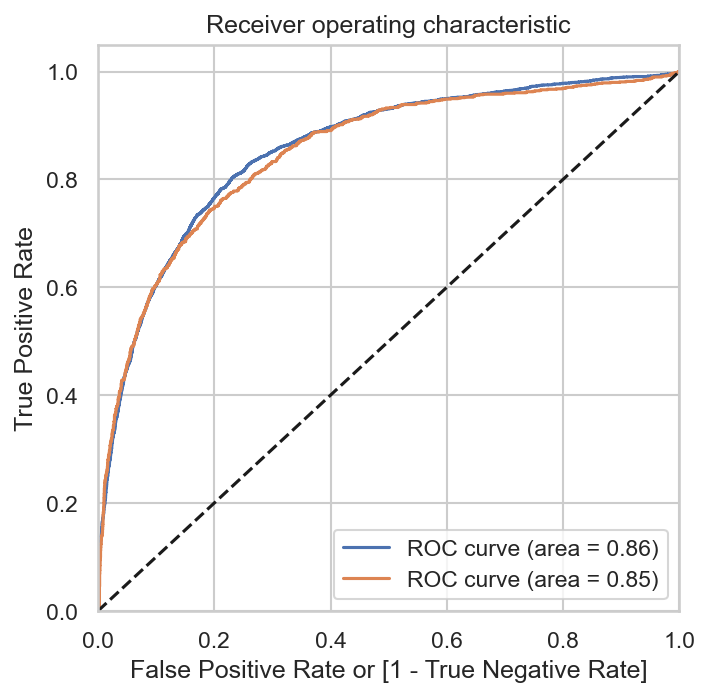

In [60]:
draw_roc(y_train, y_train_pred_prob, y_test, y_test_pred_prob)

In [61]:
print("Accuracy train: ", accuracy_score(y_train, y_train_pred))
print("Accuracy test: ", accuracy_score(y_test, y_test_pred))

Accuracy train:  0.8215693853884809
Accuracy test:  0.823051948051948


### Step 8: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to  KNN , Decision Tree, and SVM algorithm based models.  Using the default settings for each of the models, fit and score each.  We are comparing the fit time of each of the models.  We will present our findings in a `DataFrame` similar to the one below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [62]:
def model_report(model_name, model):
    print('\nSearch for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data')
    model.fit(X_train, y_train)
    optimal_th = 0.5   # start with default threshold value
    
    for i in range(0,3):
        score_list = []
        print('\nLooping decimal place', i+1) 
        th_list = [np.linspace(optimal_th-0.4999, optimal_th+0.4999, 11), 
                  # eg [ 0.0001 , 0.1008, 0.2006, 0.3004, 0.4002, 0.5, 0.5998, 0.6996, 0.7994, 0.8992, 0.9999 ]
                 np.linspace(optimal_th-0.1, optimal_th+0.1, 21), 
                  # eg 0.3xx [ 0.2 , 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 ]
                 np.linspace(optimal_th-0.01, optimal_th+0.01, 21)]
                  # eg 0.30x [ 0.29 , 0.291, 0.292, 0.293, 0.294, 0.295, 0.296, 0.297, 0.298, 0.299, 0.3  , 0.301, 0.302, 0.303, 0.304, 0.305, 0.306, 0.307, 0.308, 0.309, 0.31 ]
        for th in th_list[i]:
            y_pred = (model.predict_proba(X_test)[:,1] >= th)
            f1scor = f1_score(y_test, y_pred, average='weighted')
            score_list.append(f1scor)
            print('{:.3f}->{:.4f}'.format(th, f1scor), end=',  ')   # display score in 4 decimal pl
        optimal_th = float(th_list[i][score_list.index(max(score_list))])

    print('optimal F1 score = {:.4f}'.format(max(score_list)))
    print('optimal threshold = {:.3f}'.format(optimal_th))

    print(model_name, 'accuracy score is')
    print('Training: {:.2f}%'.format(100*model.score(X_train, y_train)))  # score uses accuracy
    print('Test set: {:.2f}%'.format(100*model.score(X_test, y_test)))   # should use cross validation

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.25)
    print('\nAdjust threshold to 0.25:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred, average='weighted'), recall_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted')))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = model.predict(X_test)
    print('\nDefault threshold of 0.50:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred, average='weighted'), recall_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted')))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= 0.75)
    print('\nAdjust threshold to 0.75:')
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred, average='weighted'), recall_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted')))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))

    y_pred = (model.predict_proba(X_test)[:,1] >= optimal_th)
    print('\nOptimal threshold {:.3f}'.format(optimal_th))
    print('Precision: {:.4f},   Recall: {:.4f},   F1 Score: {:.4f}'.format(
        precision_score(y_test, y_pred, average='weighted'), recall_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted')))
    print(model_name, 'confusion matrix: \n', confusion_matrix(y_test, y_pred))
    
    global model_f1, model_auc, model_ll, model_roc_auc
    model_f1 = f1_score(y_test, y_pred, average='weighted')

    y_pred = model.predict_proba(X_test)
    model_ll = log_loss(y_test, y_pred)
    print(model_name, 'Log-loss: {:.4f}'.format(model_ll))
    y_pred = model.predict(X_test)
    model_roc_auc = roc_auc_score(y_test, y_pred)
    print(model_name, 'roc_auc_score: {:.4f}'.format(model_roc_auc)) 
    y_pred = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    model_auc = auc(fpr, tpr)
    print(model_name, 'AUC: {:.4f}'.format(model_auc))

    # plot the ROC curve
    plt.figure(figsize = [6,6])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % model_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    # plt.savefig('roc_auc_score')
    plt.show()
  
    return

# initialise lists to collect the results to plot later
model_list = []
f1_list = []
auc_list = []
ll_list = []
roc_auc_list = []
time_list = []
train_score=[]
test_score=[]


"""""" SVC """"""

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.1032,  0.100->0.1534,  0.200->0.1779,  0.300->0.1757,  0.400->0.1680,  0.500->0.1575,  0.600->0.1466,  0.700->0.1369,  0.800->0.1239,  0.900->0.1053,  1.000->0.0118,  
Looping decimal place 2
0.100->0.1534,  0.110->0.1591,  0.120->0.1632,  0.130->0.1666,  0.140->0.1694,  0.150->0.1725,  0.160->0.1732,  0.170->0.1745,  0.180->0.1759,  0.190->0.1770,  0.200->0.1779,  0.210->0.1790,  0.220->0.1788,  0.230->0.1784,  0.240->0.1786,  0.250->0.1794,  0.260->0.1790,  0.270->0.1789,  0.280->0.1783,  0.290->0.1774,  0.300->0.1757,  
Looping decimal place 3
0.240->0.1786,  0.241->0.1786,  0.242->0.1789,  0.243->0.1789,  0.244->0.1792,  0.245->0.1791,  0.246->0.1789,  0.247->0.1790,  0.248->0.1792,  0.249->0.1791,  0.250->0.1794,  0.251->0.1796,  0.252->0.1795,  0.253->0.1797,  0.254->0.1796,  0.255->0.1797,  0.256->0.1795,  0.257->0.1794,  0.258->0.1789,  

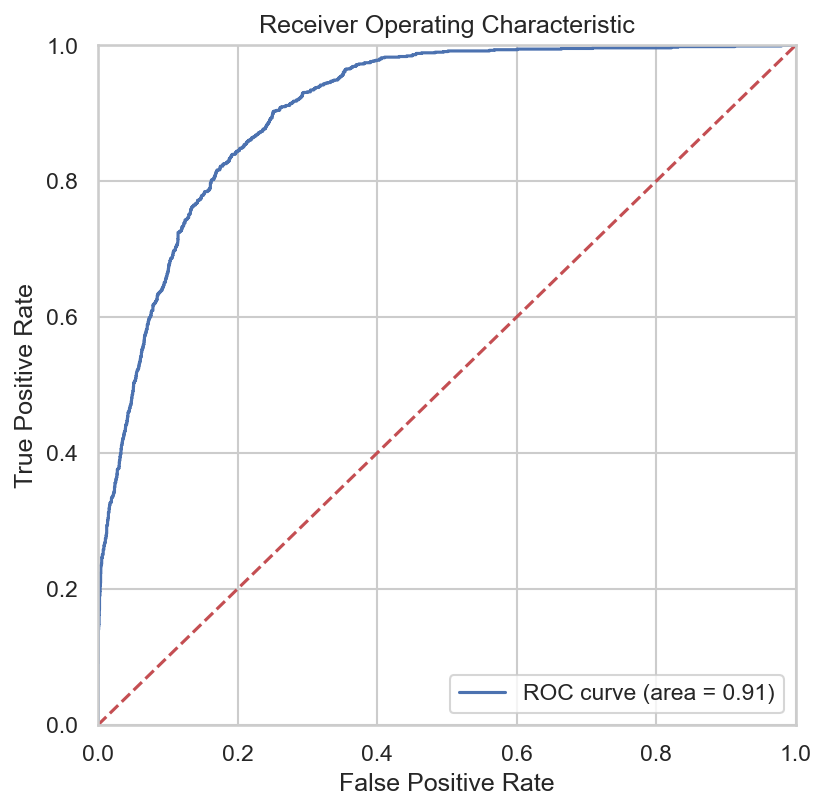

In [63]:
print('\n"""""" SVC """"""')
time1 = time.time()
svc = SVC(gamma='scale', probability=True)
model_report('SVC', svc)

model_list.append('SVC')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
# actual time spent, or
train_score.append(svc.score(X_train, y_train))
test_score.append(svc.score(X_test, y_test))
time_list.append(time.time() - time1)



"""""" LogisticRegression """"""

Search for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data
0.5442, 0.5480, 0.5451, 0.5485, 0.5458, 0.5467, 0.5445, 0.5444, 0.5431, 0.5464, 0.5467, 0.5479, 0.5440, 0.5466, 0.5487, 0.5423, 0.5476, 0.5458, 0.5515, 0.5473, 0.5448, 0.5454, 0.5454, 0.5467, 0.5454, 0.5455, 0.5441, 0.5479, 0.5432, 0.5460, 0.5433, 0.5445, 0.5465, 0.5475, 0.5472, 0.5461, 0.5459, 0.5468, 0.5479, 0.5449, 0.5432, 0.5457, 0.5440, 0.5489, 0.5449, 0.5443, 0.5478, 0.5454, 0.5453, 0.5475, 0.5455, 0.5493, 0.5476, 0.5441, 0.5440, 0.5454, 0.5458, 0.5453, 0.5476, 0.5460, 0.5440, 0.5465, 0.5485, 0.5457, 0.5458, 0.5463, 0.5470, 0.5467, 0.5481, 0.5457, 0.5447, 0.5428, 0.5427, 0.5458, 0.5464, 0.5448, 0.5464, 0.5469, 0.5467, 0.5483, 0.5463, 0.5461, 0.5440, 0.5491, 0.5463, 0.5461, 0.5447, 0.5474, 0.5485, 0.5453, 0.5474, 0.5461, 0.5463, 0.5490, 0.5447, 0.5449, 0.5461, 0.5439, 0.5437, 0.5480, 0.5483, 0.5453, 0.5460, 0.5462, 

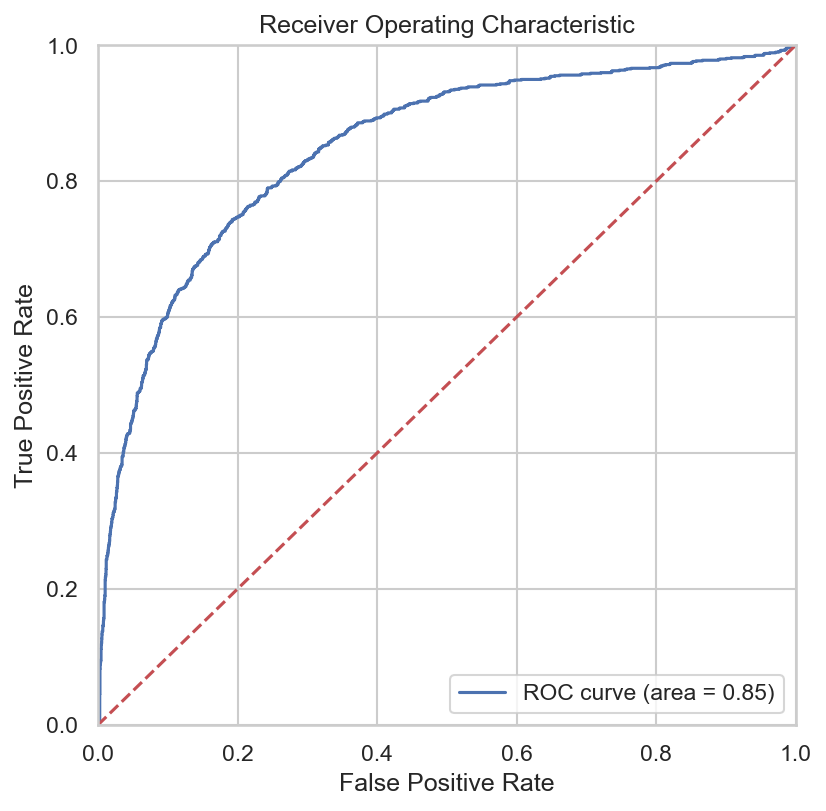

In [64]:
print('\n"""""" LogisticRegression """"""')
print('\nSearch for optimal hyperparameter C in LogisticRegresssion, vary C from 0.001 to 1000, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=21, shuffle=True)  # k folds
score_list = []
c_list = 10**np.linspace(-3,3,200)
for c in c_list:
    logit = LogisticRegression(C = c)
    cvs = (cross_val_score(logit, X_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")   # 4 decimal pl
print('optimal cv F1 score = {:.4f}'.format(max(score_list)))
optimal_c = float(c_list[score_list.index(max(score_list))])
print('optimal value of C = {:.3f}'.format(optimal_c))

time1 = time.time()
logit = LogisticRegression(C = optimal_c)
model_report('LogisticRegression', logit)

model_list.append('LogisticRegression')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
train_score.append(logreg.score(X_train, y_train))
test_score.append(logreg.score(X_test, y_test))
time_list.append(time.time() - time1)



"""""" KNN """"""

Search for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold(5) Cross Validation on train data
0.6350, 0.5947, 0.6624, 0.6263, 0.6670, 0.6464, 0.6665, 0.6493, 0.6688, 0.6546, 0.6704, 0.6508, 0.6668, 0.6533, 0.6625, 0.6516, 0.6615, 0.6514, 0.6620, 0.6515, optimal cv F1 score = 0.6704
optimal value of K = 11

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.1441,  0.100->0.1600,  0.200->0.1706,  0.300->0.1736,  0.400->0.1739,  0.500->0.1730,  0.600->0.1643,  0.700->0.1504,  0.800->0.1348,  0.900->0.1128,  1.000->0.0791,  
Looping decimal place 2
0.300->0.1736,  0.310->0.1736,  0.320->0.1736,  0.330->0.1736,  0.340->0.1736,  0.350->0.1736,  0.360->0.1736,  0.370->0.1739,  0.380->0.1739,  0.390->0.1739,  0.400->0.1739,  0.410->0.1739,  0.420->0.1739,  0.430->0.1739,  0.440->0.1739,  0.450->0.1739,  0.460->0.1730,  0.470->0.1730,  0.480->0.1730,  0.490->0.1730,  0.500->0.1730,  
Loo

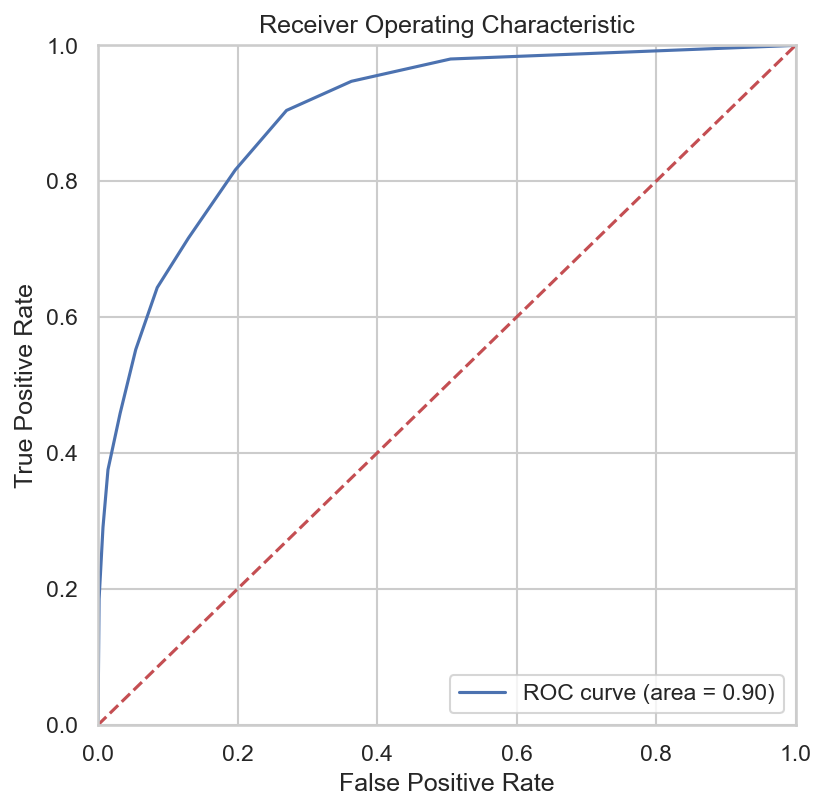


Compare with KNN classification_report (same as default threshold 0.50)
              precision    recall  f1-score   support

          -1       0.88      0.92      0.90      3215
           1       0.72      0.64      0.68      1097

    accuracy                           0.85      4312
   macro avg       0.80      0.78      0.79      4312
weighted avg       0.84      0.85      0.84      4312



In [65]:
print('\n"""""" KNN """"""')
print('\nSearch for optimal hyperparameter K in KNN, vary K from 1 to 20, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=21, shuffle=True)  #produce the k folds
k_scores = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors = k)
    cvs = cross_val_score(knn, X_train, y_train, cv=kf, scoring='f1').mean()
    k_scores.append(cvs)
    print('{:.4f}'.format(cvs), end=", ")
print('optimal cv F1 score = {:.4f}'.format(max(k_scores)))   # 4 decimal pl
optimal_k = k_scores.index(max(k_scores))+1   # index 0 is for k=1
print('optimal value of K =', optimal_k)

time1 = time.time()
knn = KNeighborsClassifier(n_neighbors = optimal_k)
model_report('KNN', knn)

print('\nCompare with KNN classification_report (same as default threshold 0.50)')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

model_list.append('KNN')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
train_score.append(knn.score(X_train, y_train))
test_score.append(knn.score(X_test, y_test))
time_list.append(time.time() - time1)


"""""" RandomForestClassifier """"""

Search for optimal n_estimators in RandomForest, vary 100 to 500, using KFold(5) Cross Validation on train data
100->0.7159, 150->0.7206, 200->0.7216, 250->0.7209, 300->0.7190, 350->0.7215, 400->0.7236, 450->0.7238, 500->0.7228, optimal F1 score = 0.7238
optimal n_estimators = 450

Search for OPTIMAL THRESHOLD, vary from 0.0001 to 0.9999, fit/predict on train/test data

Looping decimal place 1
0.000->0.1097,  0.100->0.1599,  0.200->0.1812,  0.300->0.1881,  0.400->0.1903,  0.500->0.1844,  0.600->0.1721,  0.700->0.1518,  0.800->0.1325,  0.900->0.0992,  1.000->0.0113,  
Looping decimal place 2
0.300->0.1881,  0.310->0.1896,  0.320->0.1902,  0.330->0.1904,  0.340->0.1905,  0.350->0.1906,  0.360->0.1911,  0.370->0.1914,  0.380->0.1909,  0.390->0.1904,  0.400->0.1903,  0.410->0.1898,  0.420->0.1897,  0.430->0.1893,  0.440->0.1887,  0.450->0.1881,  0.460->0.1872,  0.470->0.1857,  0.480->0.1847,  0.490->0.1846,  0.500->0.1846,  
Looping decimal place 3
0.

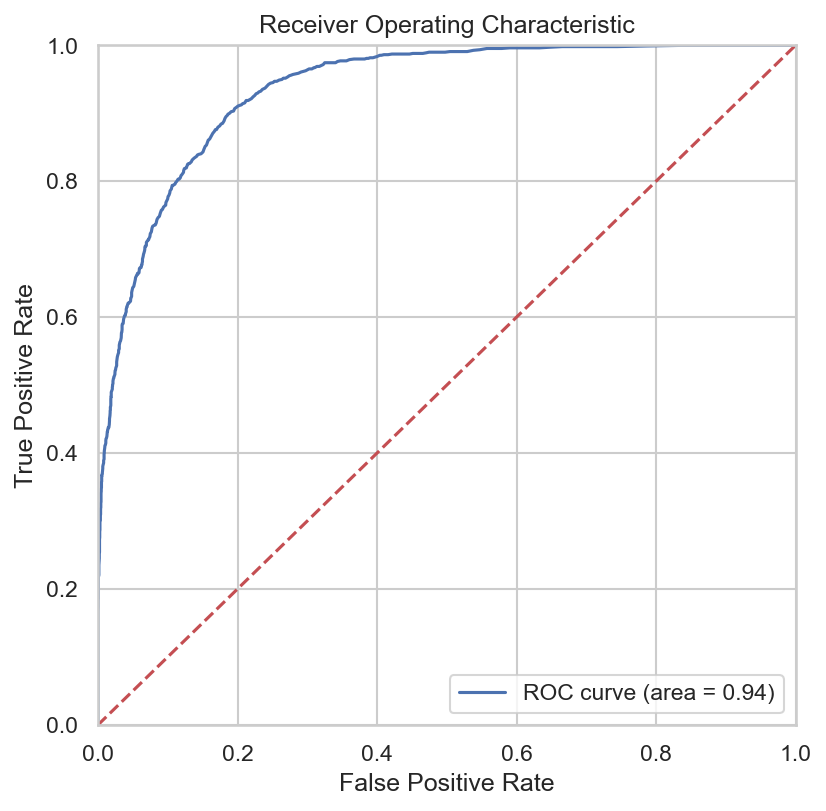

In [66]:
print('\n"""""" RandomForestClassifier """"""')

print('\nSearch for optimal n_estimators in RandomForest, vary 100 to 500, using KFold(5) Cross Validation on train data')
kf = KFold(n_splits=5, random_state=21, shuffle=True)  #produce the k folds
score_list = []
n_list = []
for n in [100, 150, 200, 250, 300, 350, 400, 450, 500]:
    randomforest = RandomForestClassifier(n_estimators=n)
    cvs = (cross_val_score(randomforest, X_train, y_train, cv=kf, scoring='f1')).mean()
    score_list.append(cvs)
    n_list.append(n)
    print('{:.0f}->{:.4f}'.format(n, cvs), end=", ")   # display score in 4 decimal place
print('optimal F1 score = {:.4f}'.format(max(score_list)))
optimal_n = int(n_list[score_list.index(max(score_list))])
print('optimal n_estimators = {:.0f}'.format(optimal_n))

time1 = time.time()
randomforest = RandomForestClassifier(n_estimators=optimal_n)
model_report('RandomForestClassifier', randomforest)

model_list.append('RandomForestClassifier')
f1_list.append(model_f1)
auc_list.append(model_auc)
ll_list.append(model_ll)
roc_auc_list.append(model_roc_auc)
train_score.append(randomforest.score(X_train, y_train))
test_score.append(randomforest.score(X_test, y_test))
time_list.append(time.time() - time1)

In [67]:
#Log the model performance data into a dataframe

res_dict={'model': model_list, 'train time': time_list,'Train Accuracy':train_score,'Test Accuracy':test_score}
results_df = pd.DataFrame(res_dict).set_index('model')

#round off the values to nearest 2 decimal places for the results

results_df = results_df.round(decimals = 2)
results_df

train time  Train Accuracy  Test Accuracy
model                                                            
SVC                        1099.20            0.83           0.83
LogisticRegression            3.18            0.82           0.82
KNN                         907.30            0.87           0.85
RandomForestClassifier      128.91            1.00           0.87

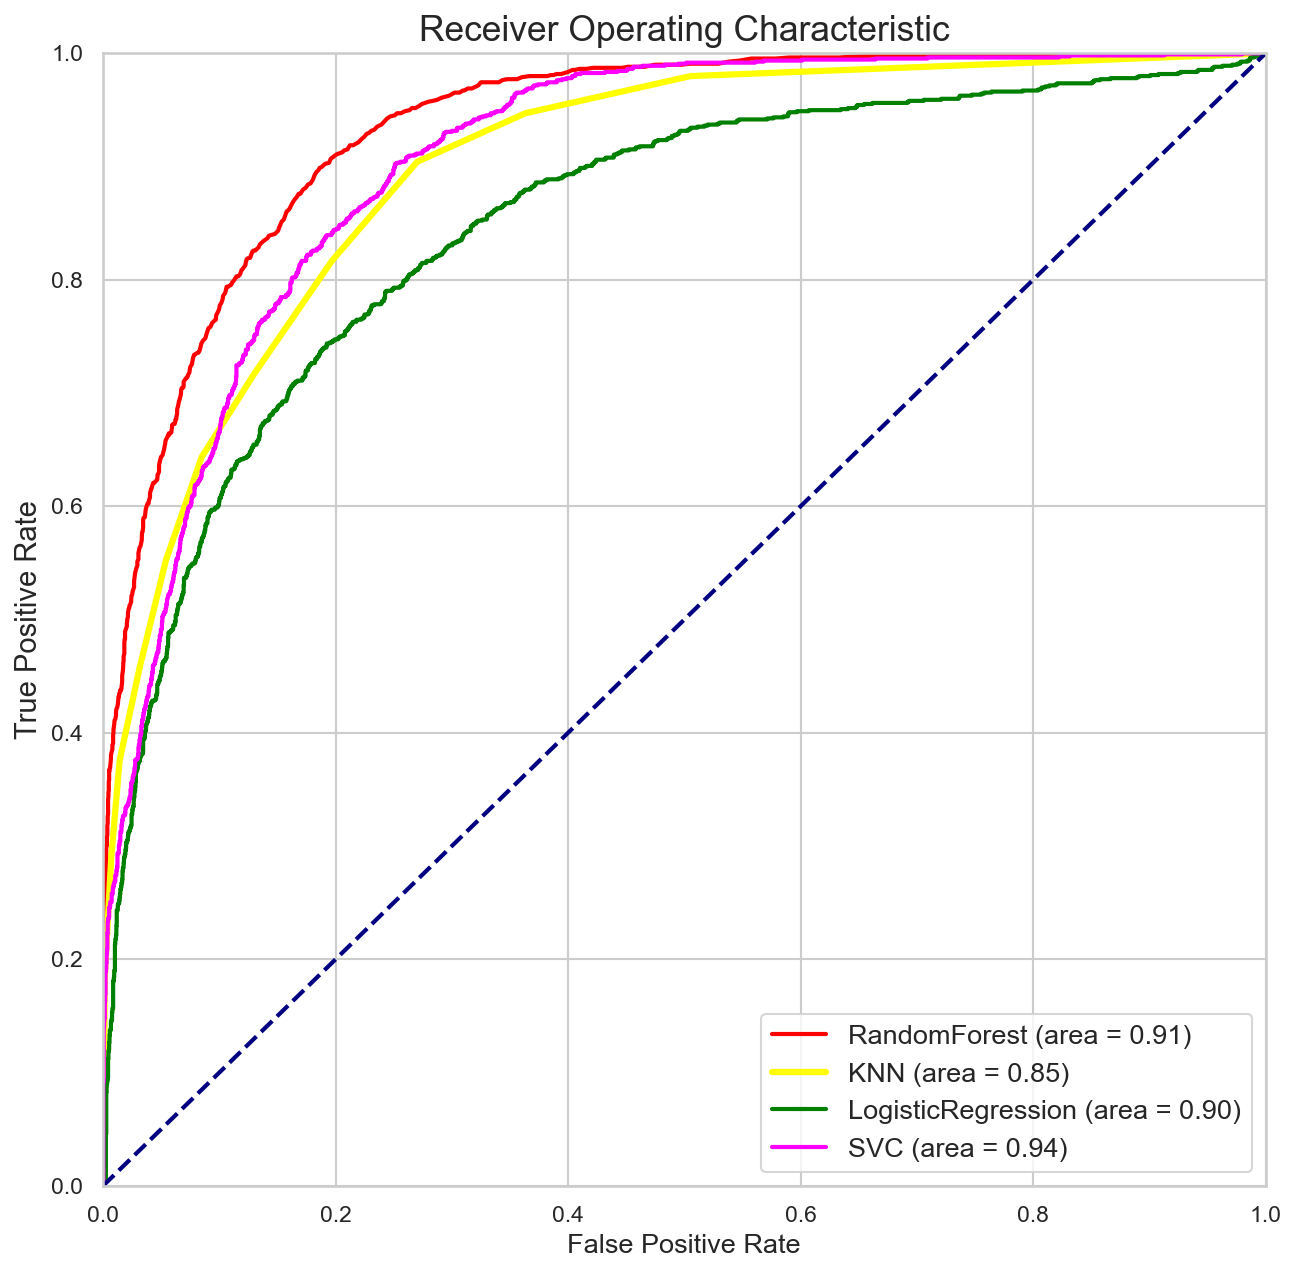

In [68]:
# plot the combined ROC curves
plt.figure(figsize=(10,10))
y_pred = randomforest.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='red',
        lw=2, label='RandomForest (area = %0.2f)' % auc_list[0])

y_pred = knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='yellow',
        lw=3, label='KNN (area = %0.2f)' % auc_list[1])

y_pred = logit.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.plot(fpr, tpr, color='green',
        lw=2, label='LogisticRegression (area = %0.2f)' % auc_list[2])
y_pred = svc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, color='magenta',
        lw=2, label='SVC (area = %0.2f)' % auc_list[3])

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=17)
plt.legend(loc='lower right', fontsize=13)
plt.show()

### Step 9: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the co related features?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- We will adjust our models performance metric as well.

**Additional Steps for Improving the Model:**
**<li>1. Removing Class imbalance using SMOTE library </li> <li>2. Hyparameter tuning using GridSearch</li> <li>3. Additional Feature engineering by removing features based on feature importance </li>**

In [69]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline

In [70]:
#Use SMOTE to correct class imbalance 

# creating an instance
sm = SMOTE(random_state=27)

# applying it to the training set

X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)


In [71]:
y_train_smote.value_counts()

-1    9667
 1    9667
Name: Label, dtype: int64

In [72]:
def class_balanced(hexcolorA, hexcolorB, edgecolor):
    
       
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    target_cnt = y_train_smote.value_counts().sort_index()

    ax.bar(target_cnt.index, target_cnt, color=[hexcolorA if i%2==0 else hexcolorB for i in range(9)],
       width=0.30, 
       edgecolor=edgecolor, 
       linewidth=0.5)

    ax.margins(0.02, 0.05)

       
    #for i in range(2):
    #ax.annotate(f'{target_cnt[i]/len(df)*100:.3}', xy=(i, target_cnt[i]+1000),
                   #va='center', ha='center',)
    
    ax.set_title('Target Variable Distribution', weight='bold', fontsize=15)
    ax.grid(axis='y', linestyle='-', alpha=0.4)

    fig.tight_layout()
    plt.show()
    return

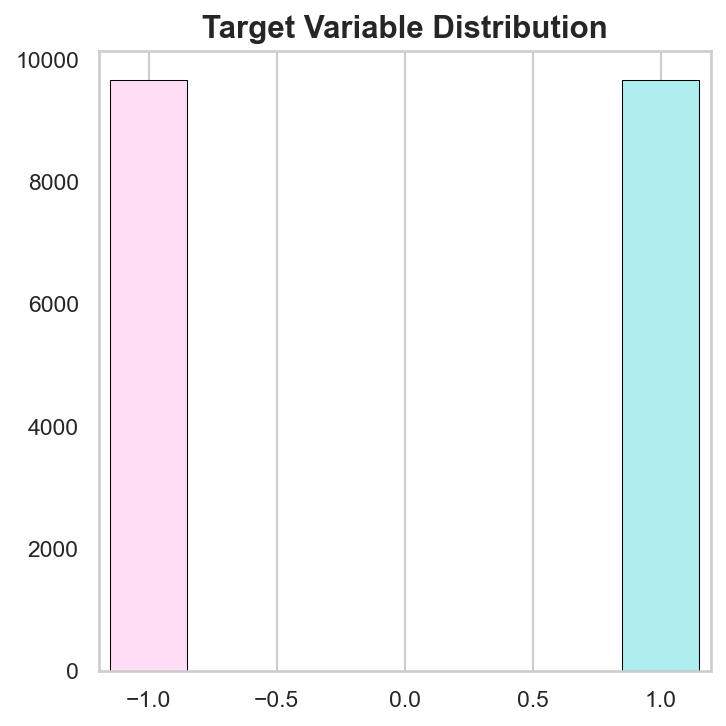

In [73]:
# Recheck inbalance after applying the smote library
class_balanced('#FFDDF4', '#AFEEEE', 'black')

**We can compare the output of cell 33 to that of cell 142 and see that smote resample method was able to balance the classes properly**

In [74]:
X_train_smote

Hour and Minutes  Hour  Minutes  Seconds  Number of announcements  \
0                  1027    10       27        1                      100   
1                  1902    19        2       16                       36   
2                   216     2       16       10                      139   
3                   805     8        5       12                       26   
4                  1726    17       26        2                      117   
...                 ...   ...      ...      ...                      ...   
19329              1350    13       50        1                      140   
19330              1304    13        4        0                      122   
19331              2213    22       13        2                      168   
19332              1714    17       14        0                      417   
19333               442     4       42        4                       84   

       Number of withdrawals  Number of announced NLRI prefixes  \
0                          7                                233   
1                          5                                 67   
2                          4                                467   
3                          2                                 36   
4                          8                                212   
...                      ...                                ...   
19329                      7                                366   
19330                      7                                256   
19331                      6                                525   
19332                      9                               1298   
19333                      5                                164   

       Number of withdrawn NLRI prefixes  Average AS-path length  \
0                                     35                       6   
1                                     33                       6   
2                                     21                       6   
3                                      7                       6   
4                                     59                       7   
...                                  ...                     ...   
19329                                105                       6   
19330                                 81                       6   
19331                                 34                       5   
19332                                106                       6   
19333                                 27                       6   

       Maximum AS-path length  ...  Maximum AS-path length10  \
0                          15  ...                         0   
1                           9  ...                         0   
2                          13  ...                         0   
3                           9  ...                         0   
4                          13  ...                         0   
...                       ...  ...                       ...   
19329                      14  ...                         0   
19330                      12  ...                         0   
19331                      12  ...                         0   
19332                      13  ...                         0   
19333                      16  ...                         0   

       Maximum AS-path length11  Maximum AS-path length12  \
0                             0                         0   
1                             0                         0   
2                             0                         1   
3                             0                         0   
4                             0                         1   
...                         ...                       ...   
19329                         0                         0   
19330                         0                         0   
19331                         1                         0   
19332                         0                         0   
19333                         0 

In [75]:
list(X_train_smote.columns)

['Hour and Minutes',
 'Hour',
 'Minutes',
 'Seconds',
 'Number of announcements',
 'Number of withdrawals',
 'Number of announced NLRI prefixes',
 'Number of withdrawn NLRI prefixes',
 'Average AS-path length',
 'Maximum AS-path length',
 'Average unique AS-path length',
 'Number of duplicate announcements',
 'Number of duplicate withdrawals',
 'Number of implicit withdrawals',
 'Average edit distance',
 'Maximum edit distance',
 'Inter-arrival time',
 'Maximum edit distance7',
 'Maximum edit distance8',
 'Maximum edit distance9',
 'Maximum edit distance10',
 'Maximum edit distance11',
 'Maximum edit distance12',
 'Maximum edit distance13',
 'Maximum edit distance14',
 'Maximum edit distance15',
 'Maximum edit distance16',
 'Maximum edit distance17',
 'Maximum AS-path length7',
 'Maximum AS-path length8',
 'Maximum AS-path length9',
 'Maximum AS-path length10',
 'Maximum AS-path length11',
 'Maximum AS-path length12',
 'Maximum AS-path length13',
 'Maximum AS-path length14',
 'Maximum 

In [76]:
# 1 MLM Logistic Regression
logmodel2 = LogisticRegression(solver='liblinear')
logmodel2.fit(X_train_smote,y_train_smote)
prediction_1 = logmodel2.predict(X_test)
# Score report
print(classification_report(y_test,prediction_1))

              precision    recall  f1-score   support

          -1       0.86      0.93      0.89      3215
           1       0.73      0.57      0.64      1097

    accuracy                           0.84      4312
   macro avg       0.79      0.75      0.76      4312
weighted avg       0.83      0.84      0.83      4312



In [77]:
# 2 MLM Decision tree
clf = RandomForestClassifier(n_estimators=150)
clf.fit(X_train_smote,y_train_smote)
prediction_2 = clf.predict(X_test)
# Score report
print(classification_report(y_test,prediction_2))

              precision    recall  f1-score   support

          -1       0.91      0.91      0.91      3215
           1       0.74      0.74      0.74      1097

    accuracy                           0.87      4312
   macro avg       0.83      0.83      0.83      4312
weighted avg       0.87      0.87      0.87      4312



In [78]:
# 3 MLM KNN
knn = KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train_smote,y_train_smote)
prediction_3 = knn.predict(X_test)
# Score report
print(classification_report(y_test,prediction_3))

              precision    recall  f1-score   support

          -1       0.95      0.71      0.81      3215
           1       0.51      0.88      0.65      1097

    accuracy                           0.76      4312
   macro avg       0.73      0.80      0.73      4312
weighted avg       0.84      0.76      0.77      4312



In [79]:
# 4 MLM SVM
svm2=svm.SVC(kernel="poly", degree=2, probability=True)
svm2.fit(X_train_smote,y_train_smote)
prediction_4 = svm2.predict(X_test)
# Score report
print(classification_report(y_test,prediction_4))

              precision    recall  f1-score   support

          -1       0.89      0.89      0.89      3215
           1       0.67      0.67      0.67      1097

    accuracy                           0.83      4312
   macro avg       0.78      0.78      0.78      4312
weighted avg       0.83      0.83      0.83      4312



**Applying HalvingGridSearchCV for best parameter selection**

In [80]:
def create_pipe(clf):

    pipeline = Pipeline([('over', SMOTE(random_state=42)),
                         ('under', RandomUnderSampler(random_state=42)),
                         ('clf', clf)])
    return pipeline

In [81]:
models = {'RandForest' : RandomForestClassifier(random_state=42),
          'LogReg' : LogisticRegression(random_state=42),
          'knn': KNeighborsClassifier(),'svm':SVC()
          }

In [82]:
for name, model, in models.items():
    clf = model
    pipeline = create_pipe(clf)
    scores = cross_val_score(pipeline, X_train, y_train, scoring='f1_macro', cv=3, n_jobs=1, error_score='raise')
    print(name, ': Mean f1 Macro: %.3f and Standard Deviation: (%.3f)' % (np.mean(scores), np.std(scores)))

RandForest : Mean f1 Macro: 0.824 and Standard Deviation: (0.003)
LogReg : Mean f1 Macro: 0.770 and Standard Deviation: (0.006)
knn : Mean f1 Macro: 0.746 and Standard Deviation: (0.004)
svm : Mean f1 Macro: 0.781 and Standard Deviation: (0.001)


In [83]:
parameters = [{'clf__solver' : ['newton-cg', 'lbfgs', 'sag', 'liblinear'],
               'clf__C' : [.1, 1, 10, 100, 1000]}]

clf = LogisticRegression(random_state=42, max_iter=500)
pipeline = create_pipe(clf)

In [84]:
pipeline.get_params()

{'memory': None,
 'steps': [('over', SMOTE(random_state=42)),
  ('under', RandomUnderSampler(random_state=42)),
  ('clf', LogisticRegression(max_iter=500, random_state=42))],
 'verbose': False,
 'over': SMOTE(random_state=42),
 'under': RandomUnderSampler(random_state=42),
 'clf': LogisticRegression(max_iter=500, random_state=42),
 'over__k_neighbors': 5,
 'over__n_jobs': None,
 'over__random_state': 42,
 'over__sampling_strategy': 'auto',
 'under__random_state': 42,
 'under__replacement': False,
 'under__sampling_strategy': 'auto',
 'clf__C': 1.0,
 'clf__class_weight': None,
 'clf__dual': False,
 'clf__fit_intercept': True,
 'clf__intercept_scaling': 1,
 'clf__l1_ratio': None,
 'clf__max_iter': 500,
 'clf__multi_class': 'auto',
 'clf__n_jobs': None,
 'clf__penalty': 'l2',
 'clf__random_state': 42,
 'clf__solver': 'lbfgs',
 'clf__tol': 0.0001,
 'clf__verbose': 0,
 'clf__warm_start': False}

In [85]:
grid = HalvingGridSearchCV(pipeline, 
                           parameters, 
                           scoring='f1_macro', 
                           cv=3).fit(X_train, y_train)


print("Best cross-validation accuracy: {:.3f}".format(grid.best_score_))
print("Test set score: {:.3f}".format(grid.score(X_test, y_test))) 
print("Best parameters: {}".format(grid.best_params_))


Best cross-validation accuracy: 0.777
Test set score: 0.778
Best parameters: {'clf__C': 0.1, 'clf__solver': 'newton-cg'}


In [86]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 

In [87]:
# instantiate the halving grid
halving_grid_svc=HalvingGridSearchCV(SVC(), param_grid, refit = True, cv=10, verbose=3, n_jobs = -1)

# fit the grid with data
halving_grid_svc.fit(X_train, y_train)


n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 1437
max_resources_: 12935
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 25
n_resources: 1437
Fitting 10 folds for each of 25 candidates, totalling 250 fits
----------
iter: 1
n_candidates: 9
n_resources: 4311
Fitting 10 folds for each of 9 candidates, totalling 90 fits
----------
iter: 2
n_candidates: 3
n_resources: 12933
Fitting 10 folds for each of 3 candidates, totalling 30 fits


HalvingGridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
                    param_grid={'C': [0.1, 1, 10, 100, 1000],
                                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                'kernel': ['rbf']},
                    refit=<function _refit_callable at 0x0000020904FABC80>,
                    verbose=3)

In [88]:
print("Best cross-validation accuracy: {:.3f}".format(halving_grid_svc.best_score_))
print("Test set score: {:.3f}".format(halving_grid_svc.score(X_test, y_test))) 
print("Best parameters: {}".format(halving_grid_svc.best_params_))

Best cross-validation accuracy: 0.852
Test set score: 0.850
Best parameters: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}


In [89]:
y_pred_SVC = halving_grid_svc.predict(X_test)

print(metrics.accuracy_score(y_test, y_pred_SVC))

0.849721706864564


In [90]:
# Score report
print(classification_report(y_test,y_pred_SVC))

              precision    recall  f1-score   support

          -1       0.88      0.92      0.90      3215
           1       0.74      0.63      0.68      1097

    accuracy                           0.85      4312
   macro avg       0.81      0.78      0.79      4312
weighted avg       0.84      0.85      0.85      4312



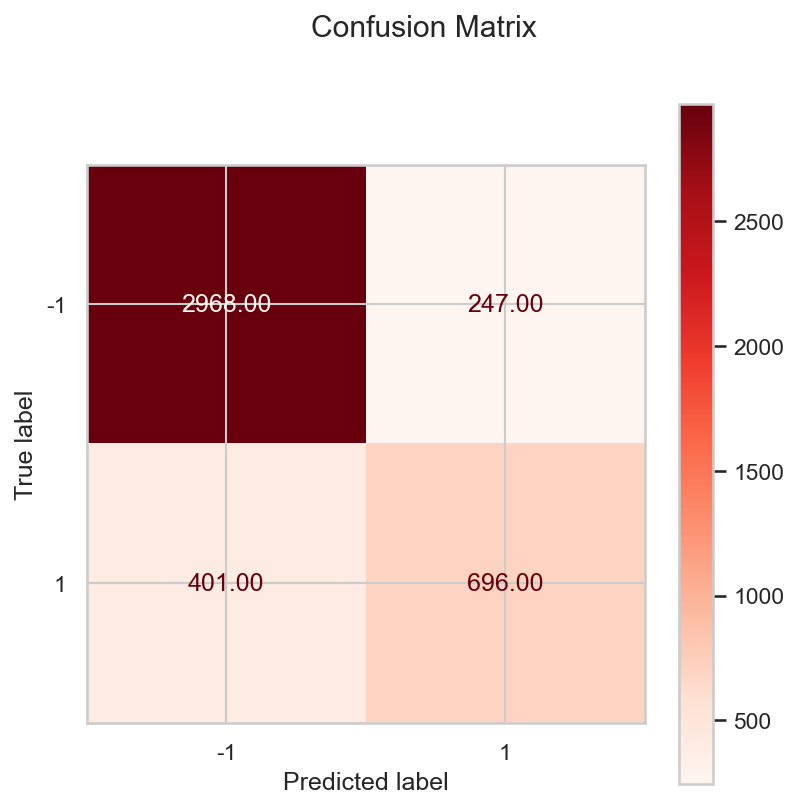

In [91]:
# Plot
plot_1 = plot_confusion_matrix(halving_grid_svc, X_test, y_test, display_labels=["-1","1"],cmap = plt.cm.Reds,values_format = '.2f')
plot_1.figure_.suptitle("Confusion Matrix")
plt.show()

**Best SVC based Model based on HalvingGridSearch results:**

In [92]:
#setup a pipeline based on GridSearch suggested results
optimum_svc_model = SVC(C= 1, degree=2, gamma= 0.0001, kernel='rbf')
optimum_pipeline = Pipeline([('over', SMOTE(random_state=42)),
                         ('under', RandomUnderSampler(random_state=42)),
                         ('clf', optimum_svc_model)])
optimum_pipeline.fit(X_train, y_train)
optimum_results = optimum_pipeline.predict(X_test)
 

In [93]:
col_names = list(df.columns)
feature_names = col_names[:-1]

Text(0.5, 0, 'Permutation Importance')

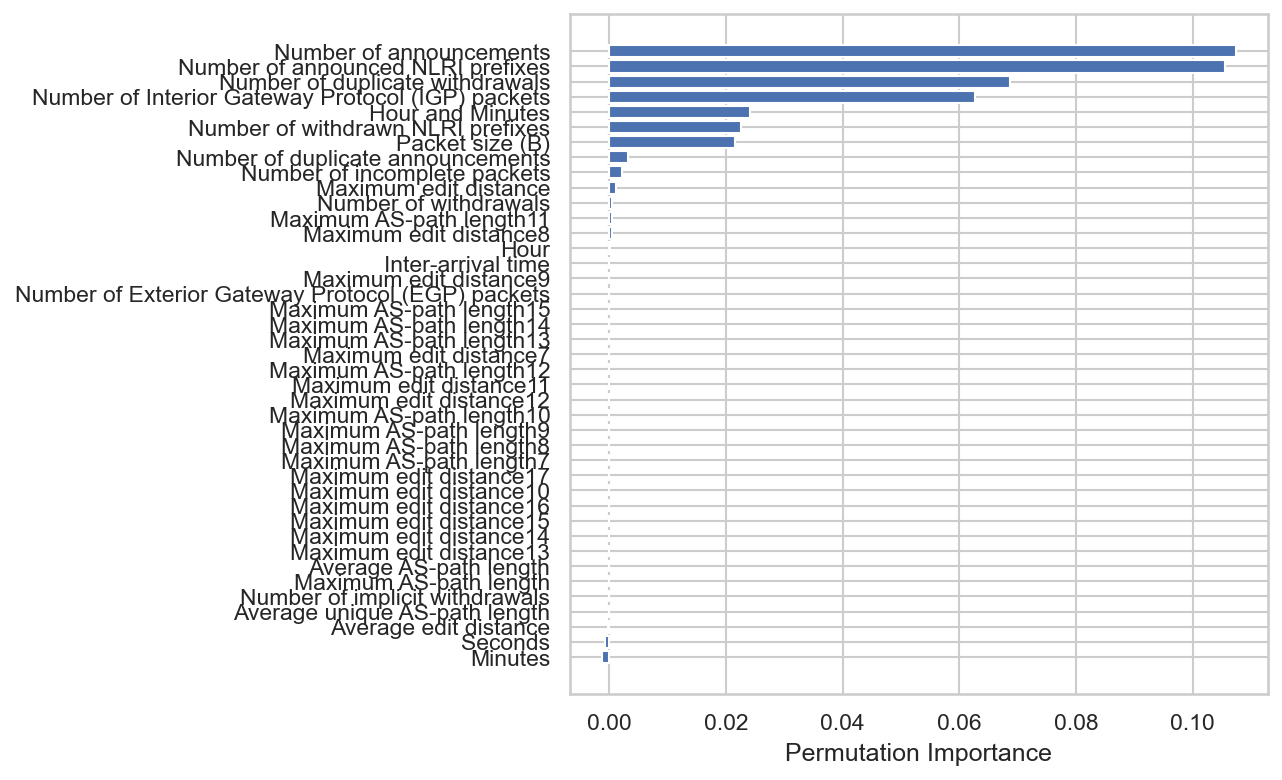

In [94]:
perm_importance = permutation_importance(optimum_pipeline, X_test, y_test)
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [95]:
features

array(['Hour and Minutes', 'Hour', 'Minutes', 'Seconds',
       'Number of announcements', 'Number of withdrawals',
       'Number of announced NLRI prefixes',
       'Number of withdrawn NLRI prefixes', 'Average AS-path length',
       'Maximum AS-path length', 'Average unique AS-path length',
       'Number of duplicate announcements',
       'Number of duplicate withdrawals',
       'Number of implicit withdrawals', 'Average edit distance',
       'Maximum edit distance', 'Inter-arrival time',
       'Maximum edit distance7', 'Maximum edit distance8',
       'Maximum edit distance9', 'Maximum edit distance10',
       'Maximum edit distance11', 'Maximum edit distance12',
       'Maximum edit distance13', 'Maximum edit distance14',
       'Maximum edit distance15', 'Maximum edit distance16',
       'Maximum edit distance17', 'Maximum AS-path length7',
       'Maximum AS-path length8', 'Maximum AS-path length9',
       'Maximum AS-path length10', 'Maximum AS-path length11',
       'Max

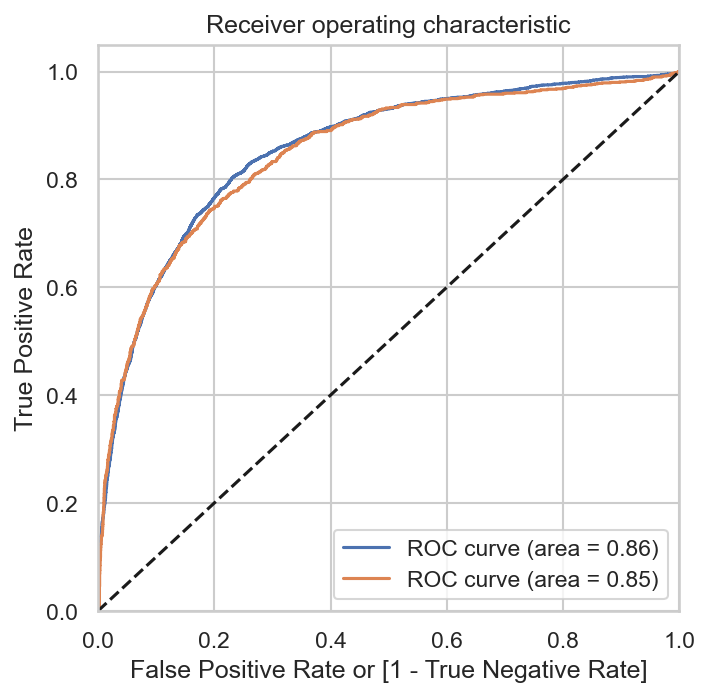

In [96]:
draw_roc(y_train, y_train_pred_prob, y_test, y_test_pred_prob)

### Step 10: Generate Predictions for new data based on our best model

 **Function to view the prediction from the optimized model from GridSearch**

In [97]:
 def Grid_Optimized_Prediction(bgpupdate):    
   
     bgp=pd.DataFrame(bgpupdate)
    
     results = optimum_pipeline.predict(bgp)
    
     print("The predicted bgp update status is: $", results)
     print("")
     print("Here is how to interpret the results:")
     print("")
     print("An outcome of  '1' indicates that there is an Anomaly in this BGP Update")
     print("")
     print("An outcome of '-1' indicates that the BGP Update is normal" )
     return

In [98]:
df.tail(15)

Hour and Minutes  Hour  Minutes  Seconds  Number of announcements  \
17232              2345    23       45        5                       41   
17233              2346    23       46        2                       82   
17234              2347    23       47       12                       21   
17235              2348    23       48        5                       78   
17236              2349    23       49        5                       59   
17237              2350    23       50        6                       44   
17238              2351    23       51        1                       42   
17239              2352    23       52        4                       29   
17240              2353    23       53        1                       59   
17241              2354    23       54       14                       41   
17242              2355    23       55       12                       41   
17243              2356    23       56        5                       31   
17244              2357    23       57        0                       44   
17245              2358    23       58        4                       65   
17246              2359    23       59       14                       57   

       Number of withdrawals  Number of announced NLRI prefixes  \
17232                      3                                 96   
17233                      4                                197   
17234                      5                                 32   
17235                      7                                227   
17236                      6                                131   
17237                      5                                 91   
17238                      5                                 63   
17239                      4                                 40   
17240                      4                                 99   
17241                      4                                 56   
17242                      5                                202   
17243                      3                                286   
17244                      6                                 96   
17245                      4                                170   
17246                      6                                 89   

       Number of withdrawn NLRI prefixes  Average AS-path length  \
17232                                 14                       5   
17233                                  9                       6   
17234                                 10                       5   
17235                                 29                       7   
17236                                 58                       6   
17237                                 19                       7   
17238                                 21                       6   
17239                                  8                       6   
17240                                 15                       7   
17241                                 11                       6   
17242                                 31                       5   
17243                                  5                       6   
17244                                 42                       6   
17245                                 24                       6   
17246                                 24                       6   

       Maximum AS-path length  ...  Maximum AS-path length11  \
17232                      11  ...                         0   
17233                      11  ...                         0   
17234                       7  ...                         0   
17235                      15  ...                         0   
17236                      13  ...                         0   
17237                      14  ...                         0   
17238                      14  ...                         0   
17239                      10  ...                         0   
17240                      14  ...                  

In [99]:
#This is going to be our random record for predictions
df[17237:]

Hour and Minutes  Hour  Minutes  Seconds  Number of announcements  \
17237              2350    23       50        6                       44   
17238              2351    23       51        1                       42   
17239              2352    23       52        4                       29   
17240              2353    23       53        1                       59   
17241              2354    23       54       14                       41   
17242              2355    23       55       12                       41   
17243              2356    23       56        5                       31   
17244              2357    23       57        0                       44   
17245              2358    23       58        4                       65   
17246              2359    23       59       14                       57   

       Number of withdrawals  Number of announced NLRI prefixes  \
17237                      5                                 91   
17238                      5                                 63   
17239                      4                                 40   
17240                      4                                 99   
17241                      4                                 56   
17242                      5                                202   
17243                      3                                286   
17244                      6                                 96   
17245                      4                                170   
17246                      6                                 89   

       Number of withdrawn NLRI prefixes  Average AS-path length  \
17237                                 19                       7   
17238                                 21                       6   
17239                                  8                       6   
17240                                 15                       7   
17241                                 11                       6   
17242                                 31                       5   
17243                                  5                       6   
17244                                 42                       6   
17245                                 24                       6   
17246                                 24                       6   

       Maximum AS-path length  ...  Maximum AS-path length11  \
17237                      14  ...                         0   
17238                      14  ...                         0   
17239                      10  ...                         0   
17240                      14  ...                         0   
17241                      12  ...                         1   
17242                      10  ...                         0   
17243                       7  ...                         0   
17244                       8  ...                         0   
17245                       9  ...                         0   
17246                       9  ...                         0   

       Maximum AS-path length12  Maximum AS-path length13  \
17237                         0                         1   
17238                         0                         1   
17239                         0                         0   
17240                         0                         1   
17241                         0                         0   
17242                         0                         0   
17243                         0                         0   
17244                         0                         0   
17245                         0                         0   
17246                         0                         0   

       Maximum AS-path length14  Maximum AS-path length15  \
17237                         0                         0   
17238                         0                         0   
17239                         0                         0   
17240                         0                         0   
1

In [100]:
newbgpupdate=df[17237:]
newbgpupdate= newbgpupdate.drop("Label", axis=1)

In [101]:
Grid_Optimized_Prediction(newbgpupdate)

The predicted bgp update status is: $ [-1 -1 -1 -1 -1 -1 -1 -1  1 -1]

Here is how to interpret the results:

An outcome of  '1' indicates that there is an Anomaly in this BGP Update

An outcome of '-1' indicates that the BGP Update is normal


### Result Summary:
>**We can see that the latest model based on GridSearchCV is pretty accurate. It got one prediction wrong which is in line with the accuracy rate on test data and ROC characterestics**

**Findings and Actionable Insights:**
> 1. The objective of this capstone project was to come up with an optimum classification model to predict whether a bgp update message can be classified as anomalous or normal based on the update message attributes.
2. I analyzed 37  numerical variables which capture the various attributed of a typical BGP protocol update to build the model.
3. Exploratory data analysis showed absence of null values in the dataset, and the data is imbalanced, where “1” anomalous message is the majority class.
4. Univariate analysis revealed that Average_AS_Path length and Number of Implicit withdrawals does not help very much when it comes to predicting the target variable. Some numerical features tend to predict the target variable much better (for example: ['Maximum AS-path length', 'Number of duplicate announcements', 'Maximum edit distance', 'Number of Exterior Gateway Protocol (EGP) packets']  etc.)
5. Dataset preprocessing of numerical data was done using standscaler and MinMax scaler 
6. Basic models were built using K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.
7. The most important features in predicting whether a BGP update is anomalous  based on the Support Vector model was  
['Hour and Minutes', 'Hour', 'Minutes', 'Seconds',
       'Number of announcements', 'Number of withdrawals',
       'Number of announced NLRI prefixes',
       'Number of withdrawn NLRI prefixes', 'Average AS-path length',
       'Maximum AS-path length', 'Average unique AS-path length',
       'Number of duplicate announcements',
       'Number of duplicate withdrawals',
       'Number of implicit withdrawals']
8. GridSearch and Halving GridSearch was used to find the best parameters. The best parameters derived from Gridsearch were as follows: {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}. SMOTE library was used to remedy the class imbalance. 
9. Radial Basis Kernel function was used to find a non-linear classifier, C was set to 1 to control error based on the RIPE dataset, to minimize the cost function. Gamma was set to a low value to figure out the optimum curvature in the decision boundary.
10. Support Vector model gave the best performance  with Halving GridSearchCV and the best test AUC was 0.86 which was similar to the results reported by researchers at CAIDA, RIPE, and Simon Fraser University in previous research reports.


### Next Steps in the Classifier Model Enhancement: 

> 1. Fine Tuning the model based on domain knowledge and feature importance results
2. We could reduce the dimensions/features further to tune the model.</li>
3. Support Vector Model training even with HalvingGridSearch was very slow. </li>
4.  There are some new libraries like T-POT https://epistasislab.github.io/tpot/using/ that use genetic algorithms for hyperparameter tuning to derive the best pipeline for this classification problem. For best feature selection we could use a library like YellowBrick  https://www.scikit-yb.org/en/latest/api/model_selection/importances.html
5. Ensemble models, XGBoost could be used as next step in improving the performance of the current SVM model
6. Neural Networks/Autoencoders and LSTM based model seems to be well suited for this class of problems. 